## Code to calculate similarity metrics between pitch histograms of recordings of the same tab, but different mawazin
### Uses the non-weighted probability distribution function (number of note counts per score) to calculate metrics

In [1]:
# Autoreload libraries
%load_ext autoreload
%autoreload 2

In [2]:
import utils as u
from utils import Track
import numpy as np
import matplotlib.pyplot as plt
import pickle

TRACKS_FILE = 'tracks.pkl'

In [3]:
# Open tracks file with pickle
with open(TRACKS_FILE, 'rb') as f:
    tracks = pickle.load(f)

# Load midi_range
midi_range = Track.midi_range

In [4]:
# Make a list of all the mizan and tabu, and their combinations
tubu = []
mawazin = []
for id, track in tracks.items():
    tab   = track.tab
    mizan = track.mizan
    # If not in the lists save them
    if tab not in tubu:
        tubu.append(tab)
    if mizan not in mawazin:
        mawazin.append(mizan)

combinations = []
for tab in tubu:
    for mizan in mawazin:
        combinations.append(mizan+"--"+tab)

display(combinations)

['basīṭ--rasd althayl',
 'quddām--rasd althayl',
 'qā’im-waniṣf--rasd althayl',
 'bṭāyḥī--rasd althayl',
 'darj--rasd althayl',
 'al-ḥijāz--rasd althayl',
 'basīṭ--raml al-māyah',
 'quddām--raml al-māyah',
 'qā’im-waniṣf--raml al-māyah',
 'bṭāyḥī--raml al-māyah',
 'darj--raml al-māyah',
 'al-ḥijāz--raml al-māyah',
 'basīṭ--ghribat al-husayn',
 'quddām--ghribat al-husayn',
 'qā’im-waniṣf--ghribat al-husayn',
 'bṭāyḥī--ghribat al-husayn',
 'darj--ghribat al-husayn',
 'al-ḥijāz--ghribat al-husayn',
 'basīṭ--ghribat al-ḥusayn',
 'quddām--ghribat al-ḥusayn',
 'qā’im-waniṣf--ghribat al-ḥusayn',
 'bṭāyḥī--ghribat al-ḥusayn',
 'darj--ghribat al-ḥusayn',
 'al-ḥijāz--ghribat al-ḥusayn',
 'basīṭ--al-istihlal',
 'quddām--al-istihlal',
 'qā’im-waniṣf--al-istihlal',
 'bṭāyḥī--al-istihlal',
 'darj--al-istihlal',
 'al-ḥijāz--al-istihlal',
 'basīṭ--al-iṣbahān',
 'quddām--al-iṣbahān',
 'qā’im-waniṣf--al-iṣbahān',
 'bṭāyḥī--al-iṣbahān',
 'darj--al-iṣbahān',
 'al-ḥijāz--al-iṣbahān',
 'basīṭ--al-ḥijāz al-k

In [5]:
# Create a dictionary with the pdfs of each class
pdf_classes = {}
for comb in combinations:
    pdf_classes[comb] = [np.zeros((0,35)), 0]

for id, track in tracks.items():
    tab   = track.tab
    mizan = track.mizan
    comb  = mizan+"--"+tab
    pdf   = track.get_pdf_and_length()[0]
    N     = track.get_pdf_and_length()[1] 
    pdf_classes[comb][0] = np.vstack((pdf_classes[comb][0],pdf))
    pdf_classes[comb][1] = pdf_classes[comb][1]+N
    
# Remove classes with no samples
null_classes = []
for comb in pdf_classes.keys():
    if pdf_classes[comb][1] == 0:
        null_classes.append(comb)

for null_class in null_classes:
    del pdf_classes[null_class]

for comb in pdf_classes.keys():
    pdf_classes[comb][0] = np.mean(pdf_classes[comb][0], axis=0)

Optionally, we can plot the pdfs

In [ ]:
# Plot the pdfs
for tab in tubu:
    # Get combinations with 'rasd althayl'
    rasd_combs = [comb for comb in pdf_classes.keys() if comb.split("--")[1] == tab]

    # Calculate number of rows and columns for subplots
    num_plots = len(rasd_combs)
    num_rows = (num_plots // 2) + (num_plots % 2)
    num_cols = min(2, num_plots)  # Ensure maximum 2 columns

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    fig.suptitle("Tab: " + tab)

    # Flatten the axes if there's only one row or column
    if num_plots == 1:
        axes = np.array([[axes]])

    # Plot each combination on a separate subplot
    for idx, comb in enumerate(rasd_combs):
        row = idx // num_cols
        col = idx % num_cols
        ax = axes[row, col]
        ax.bar(x=np.arange(48, 83), height=pdf_classes[comb][0])
        ax.set_title(comb)

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()


Now let's run the similarity tests, to compare between PDFs of the same tab, but different mawazin

In [6]:
# Run similarity tests

# Chi Square ----------------------------------------------------------------------
test_chi_square = {}
for tab in tubu:
    test_chi_square[tab]={}

for comb1 in pdf_classes.keys():
    parts1 = comb1.split('--')
    tab1   = parts1[1]
    mizan1 = parts1[0]
    for comb2 in pdf_classes.keys():
        parts2 = comb2.split('--')
        tab2   = parts2[1]
        mizan2 = parts2[0]
        if tab1 == tab2:
            test_chi_square[tab1][mizan1+"--"+mizan2] = u.chi_square_test(frequencies1=pdf_classes[comb1][0], frequencies2=pdf_classes[comb2][0], total_sample_size_1=pdf_classes[comb1][1], total_sample_size_2=pdf_classes[comb2][1])[1]       
         

# Pearson correlation similarity -------------------------------------------------------------
test_cov = {}
for tab in tubu:
    test_cov[tab]={}

for comb1 in pdf_classes.keys():
    parts1 = comb1.split('--')
    tab1   = parts1[1]
    mizan1 = parts1[0]
    for comb2 in pdf_classes.keys():
        parts2 = comb2.split('--')
        tab2   = parts2[1]
        mizan2 = parts2[0]
        if tab1 == tab2:
            test_cov[tab1][mizan1+"--"+mizan2] = u.pearson_correlation(pdf_classes[comb1][0], pdf_classes[comb2][0])                     

# bhattacharyya distance similarity -------------------------------------------------------------
test_bd = {}
for tab in tubu:
    test_bd[tab]={}

for comb1 in pdf_classes.keys():
    parts1 = comb1.split('--')
    tab1   = parts1[1]
    mizan1 = parts1[0]
    for comb2 in pdf_classes.keys():
        parts2 = comb2.split('--')
        tab2   = parts2[1]
        mizan2 = parts2[0]
        if tab1 == tab2:
            test_bd[tab1][mizan1+"--"+mizan2] = u.bhattacharyya_distance(pdf_classes[comb1][0], pdf_classes[comb2][0])         

# js_divergence similarity -------------------------------------------------------------
test_js = {}
for tab in tubu:
    test_js[tab]={}

for comb1 in pdf_classes.keys():
    parts1 = comb1.split('--')
    tab1   = parts1[1]
    mizan1 = parts1[0]
    for comb2 in pdf_classes.keys():
        parts2 = comb2.split('--')
        tab2   = parts2[1]
        mizan2 = parts2[0]
        if tab1 == tab2:
            test_js[tab1][mizan1+"--"+mizan2] = u.js_divergence(pdf_classes[comb1][0], pdf_classes[comb2][0])     

# Make a dictionary with all the tests and their results
tests = {"Chi square test (p-value)": test_chi_square, 
         "Pearson Correlation": test_cov,
         "JS Divergence" : test_js, 
         "Bhattacharyya Distance" : test_bd}

NEW TEST ---------------------------------------------------------------------------------


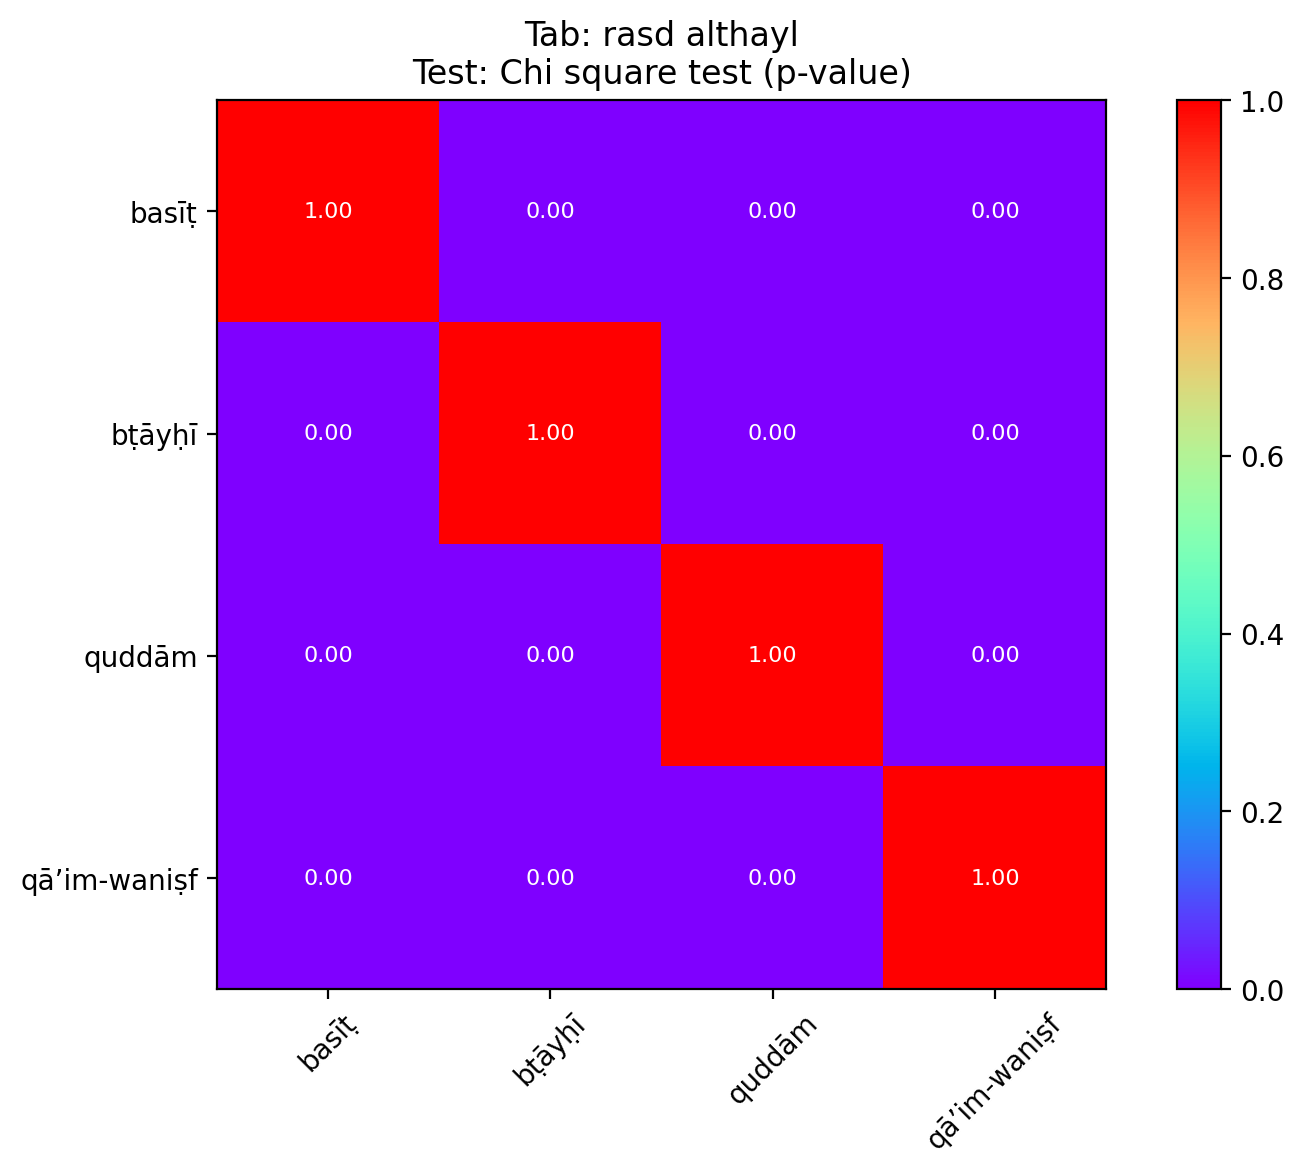

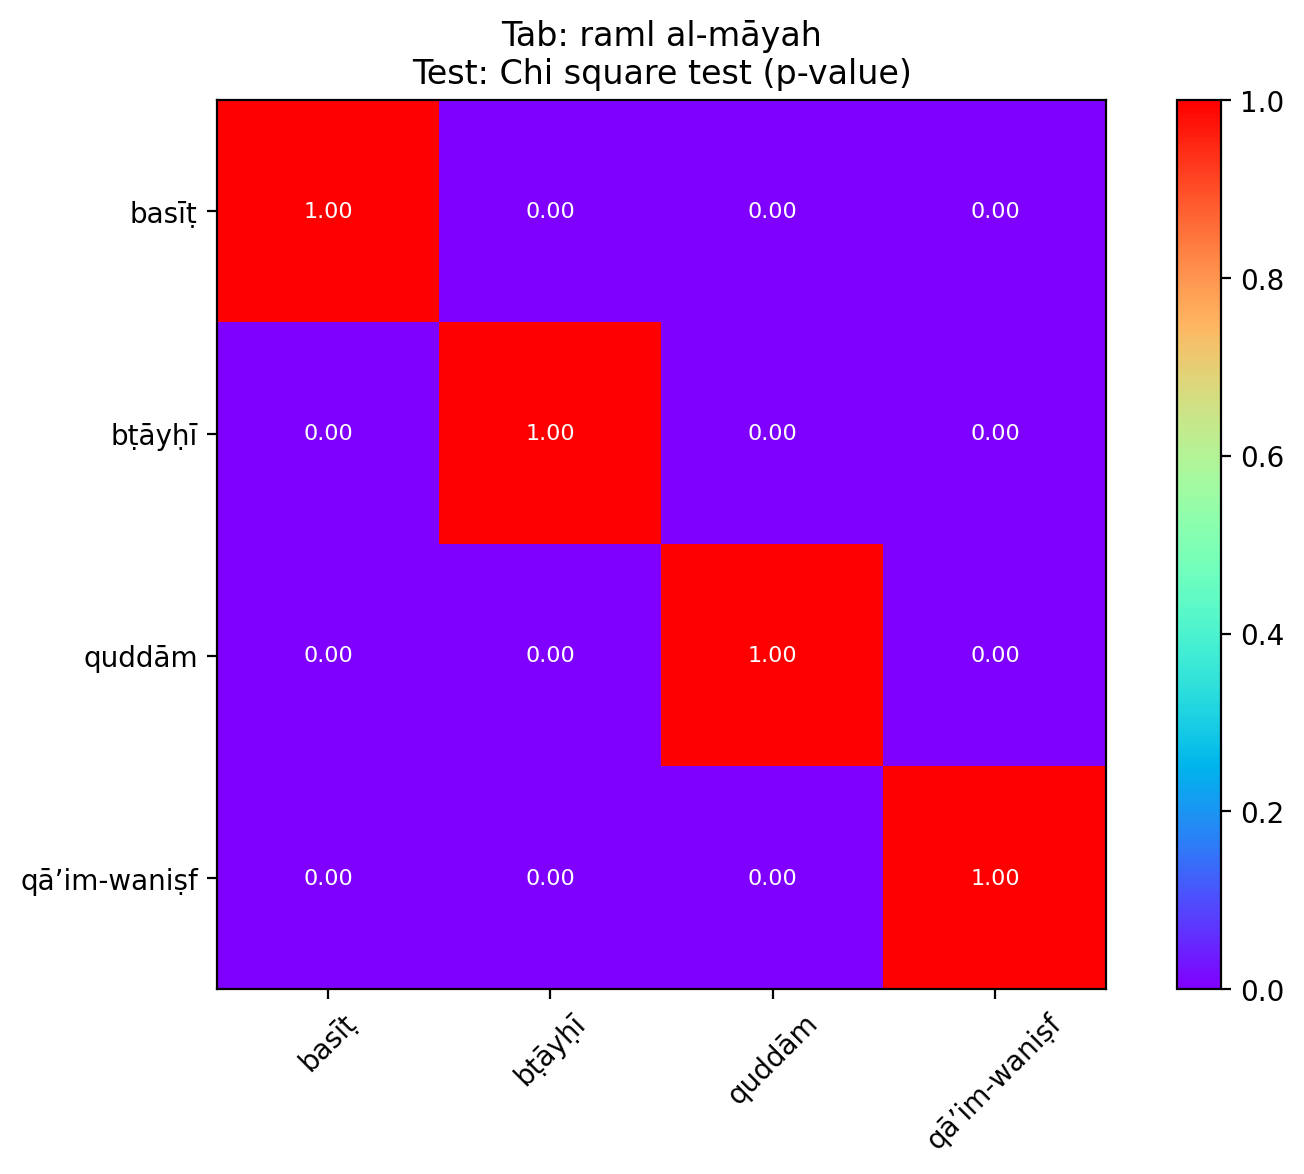

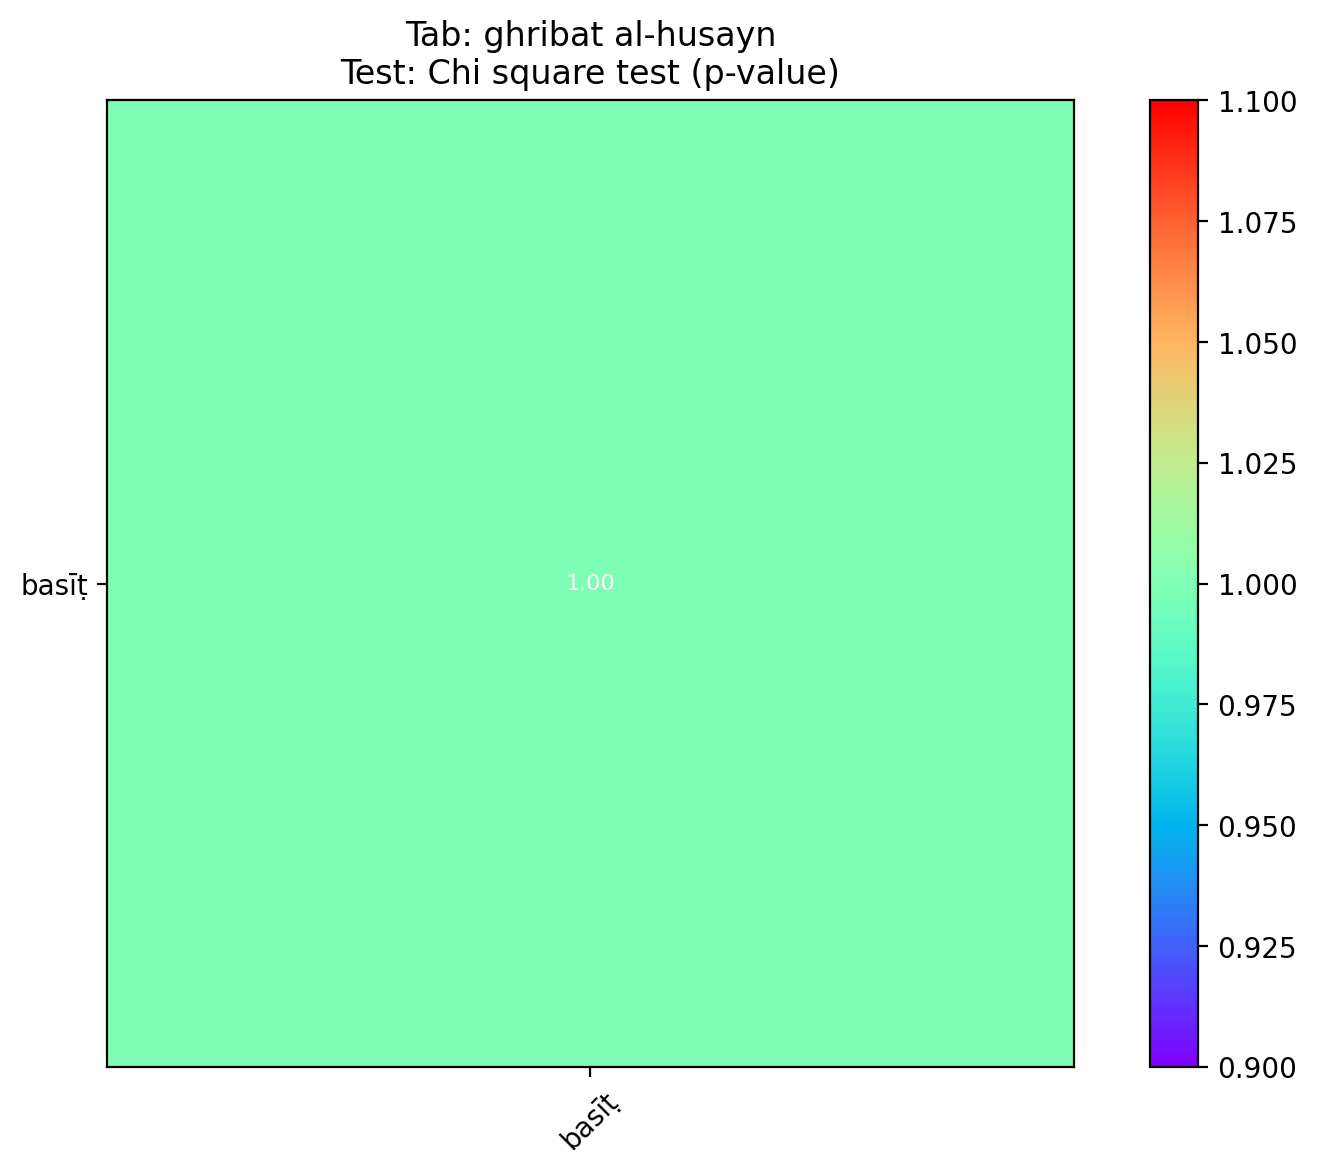

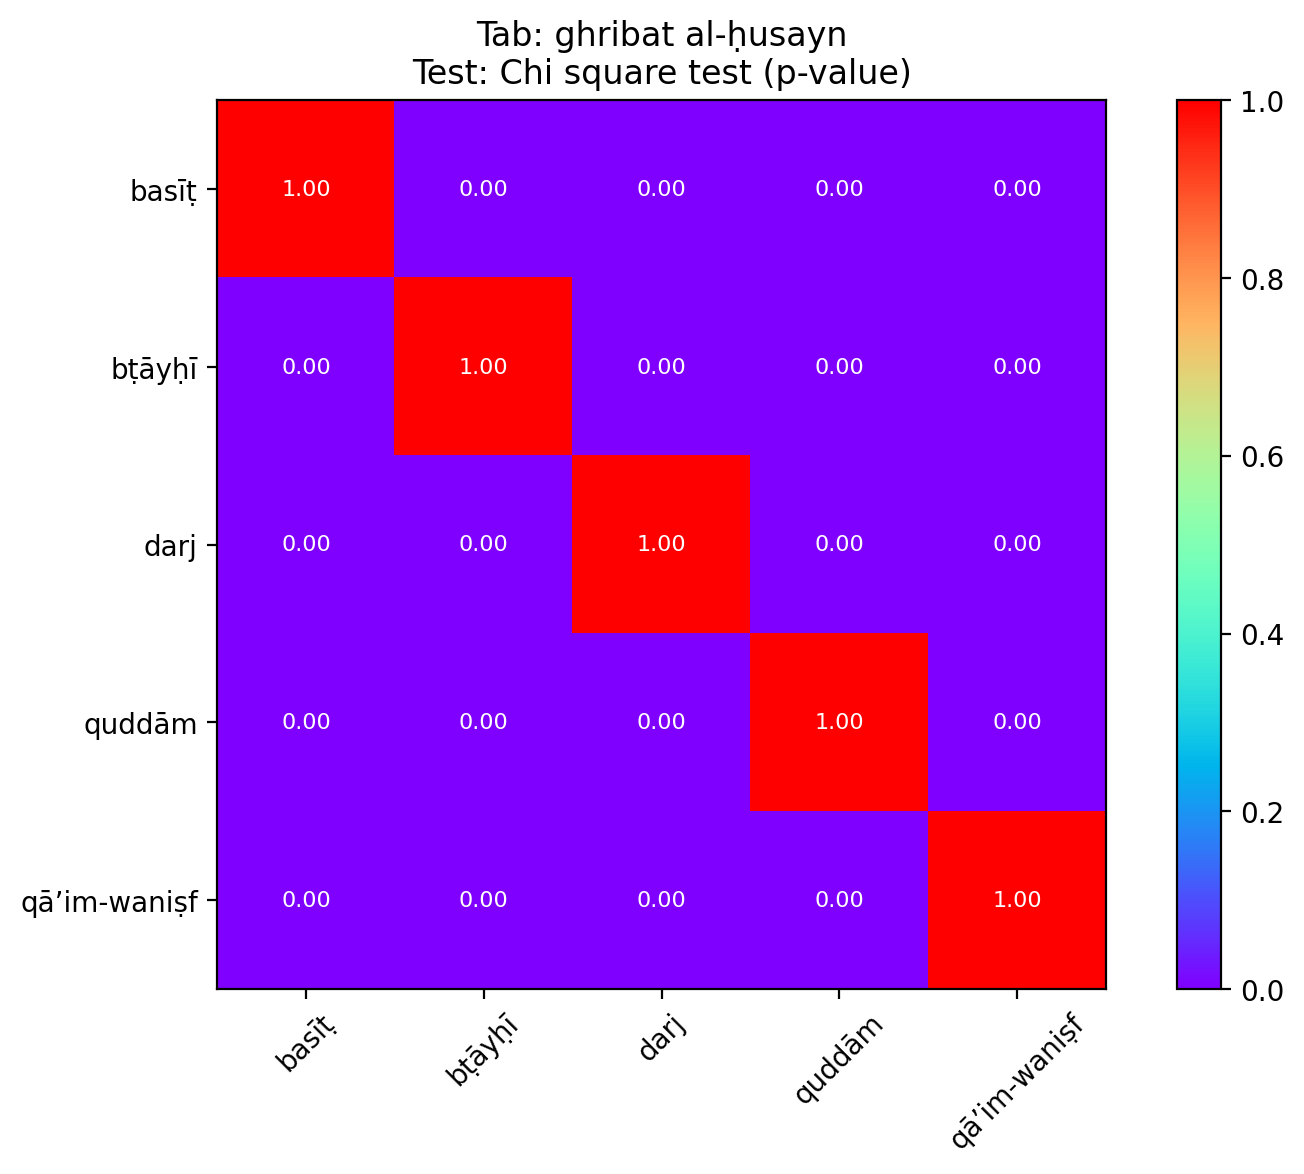

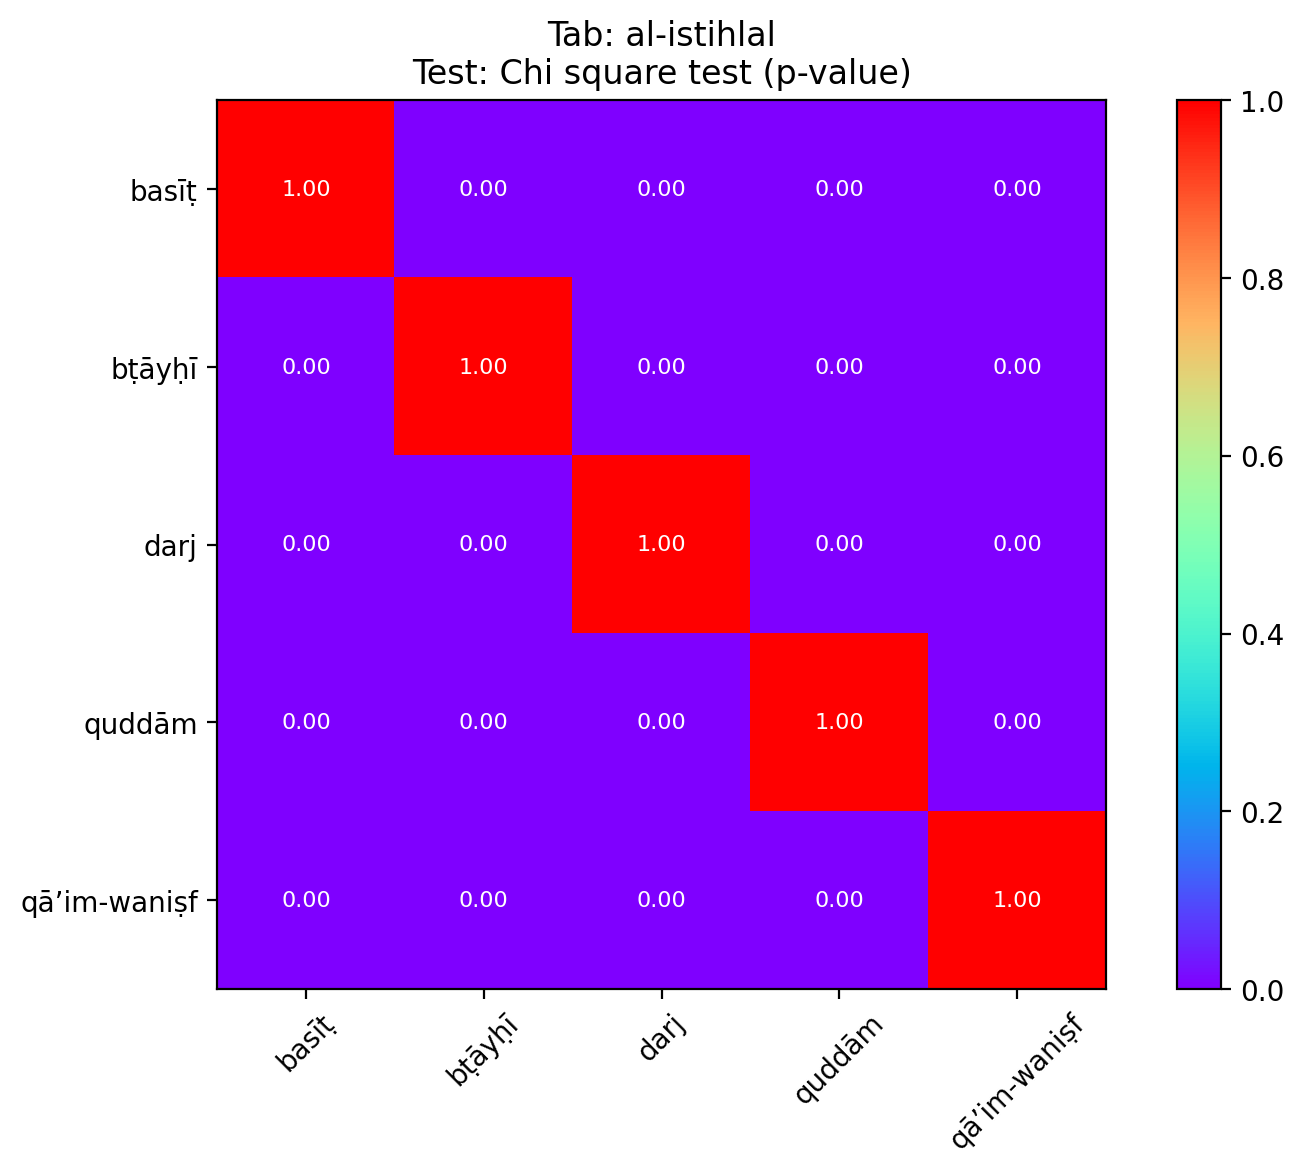

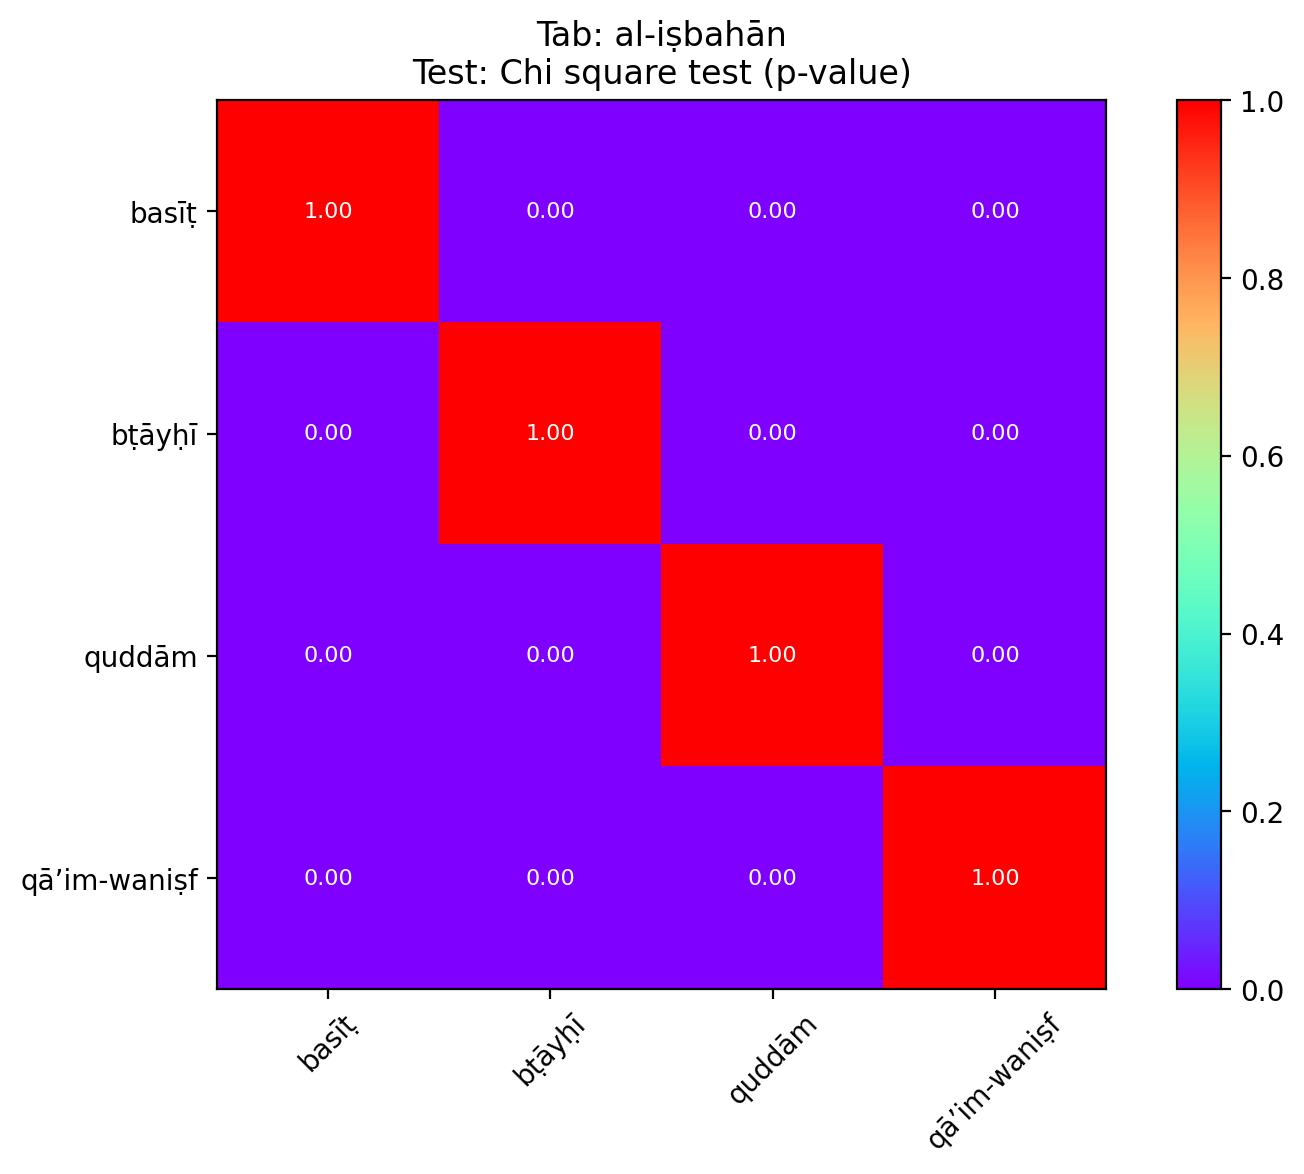

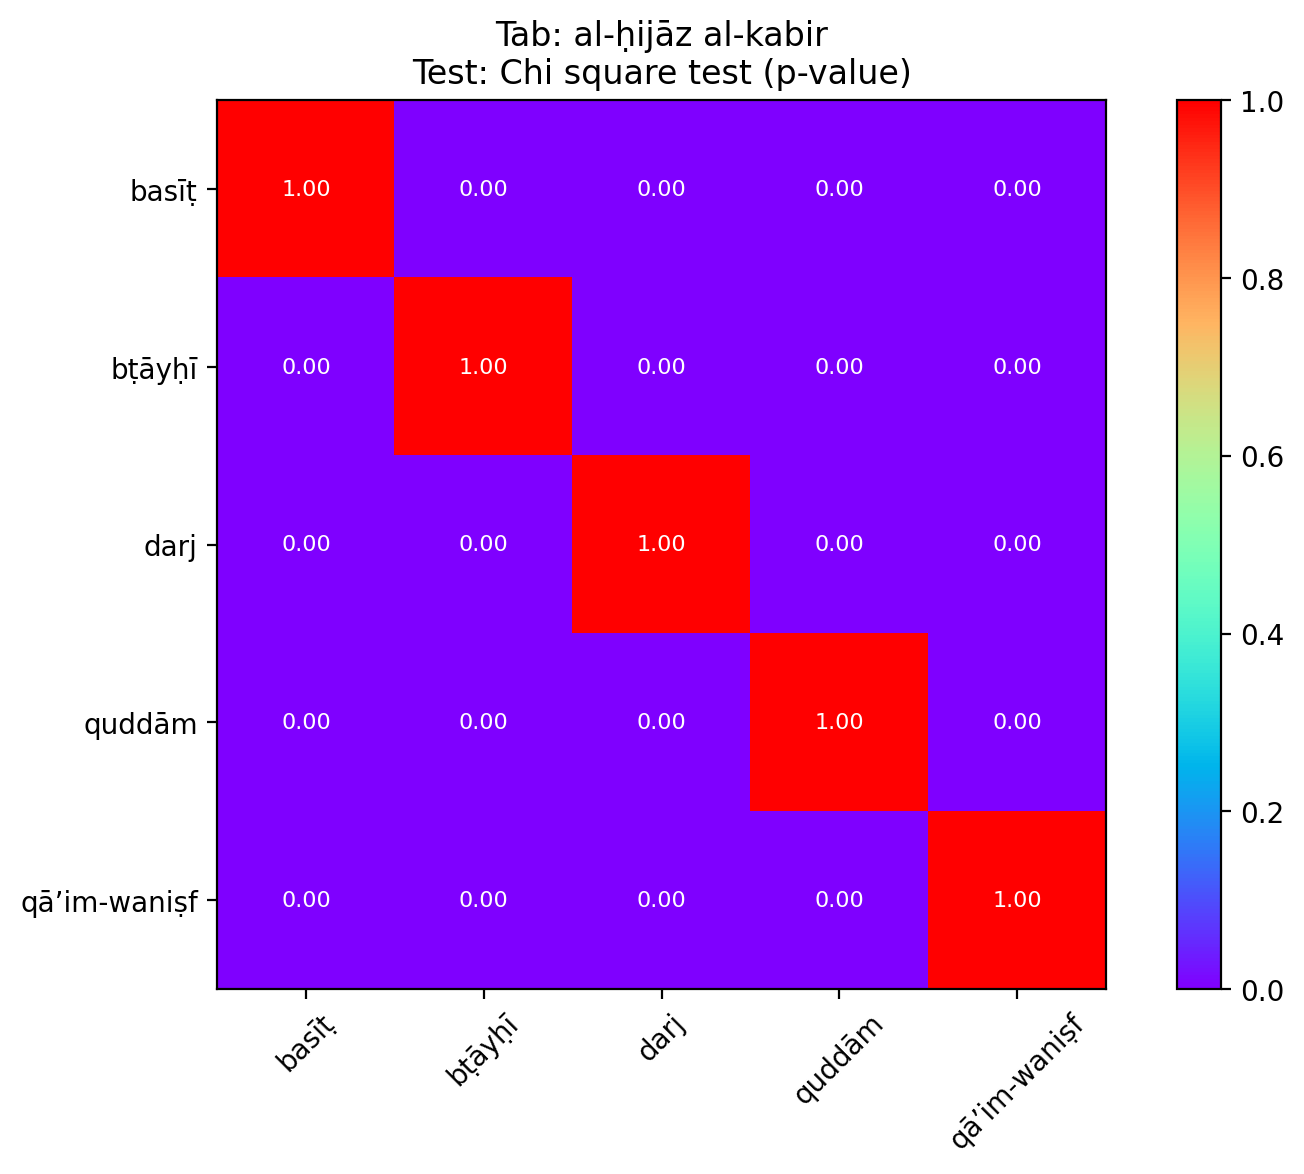

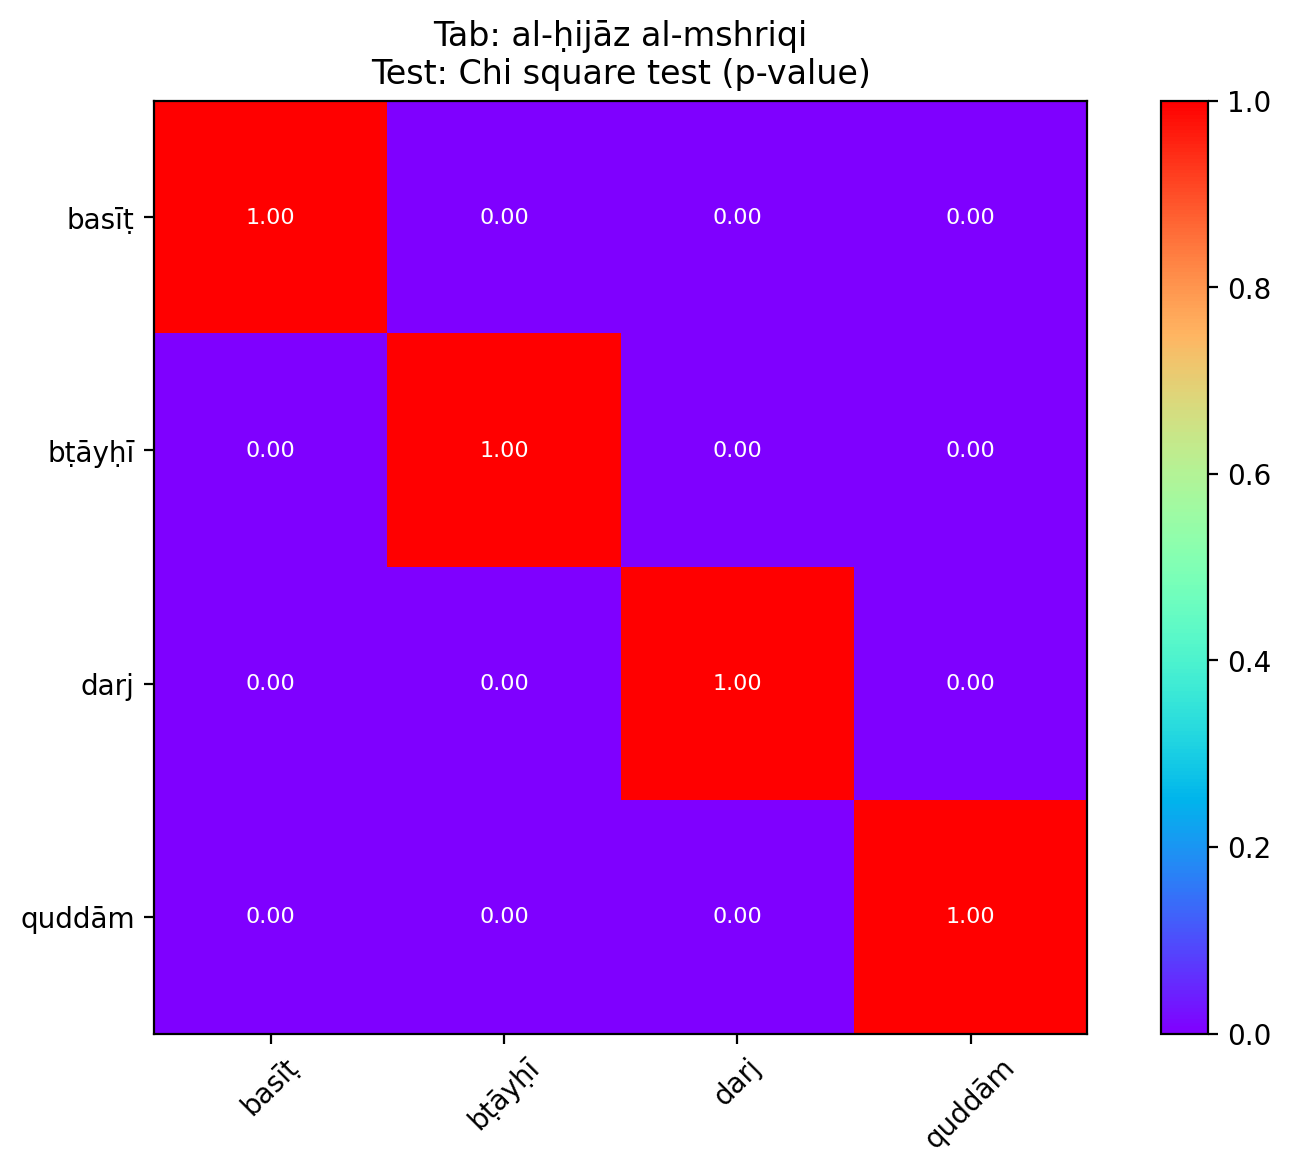

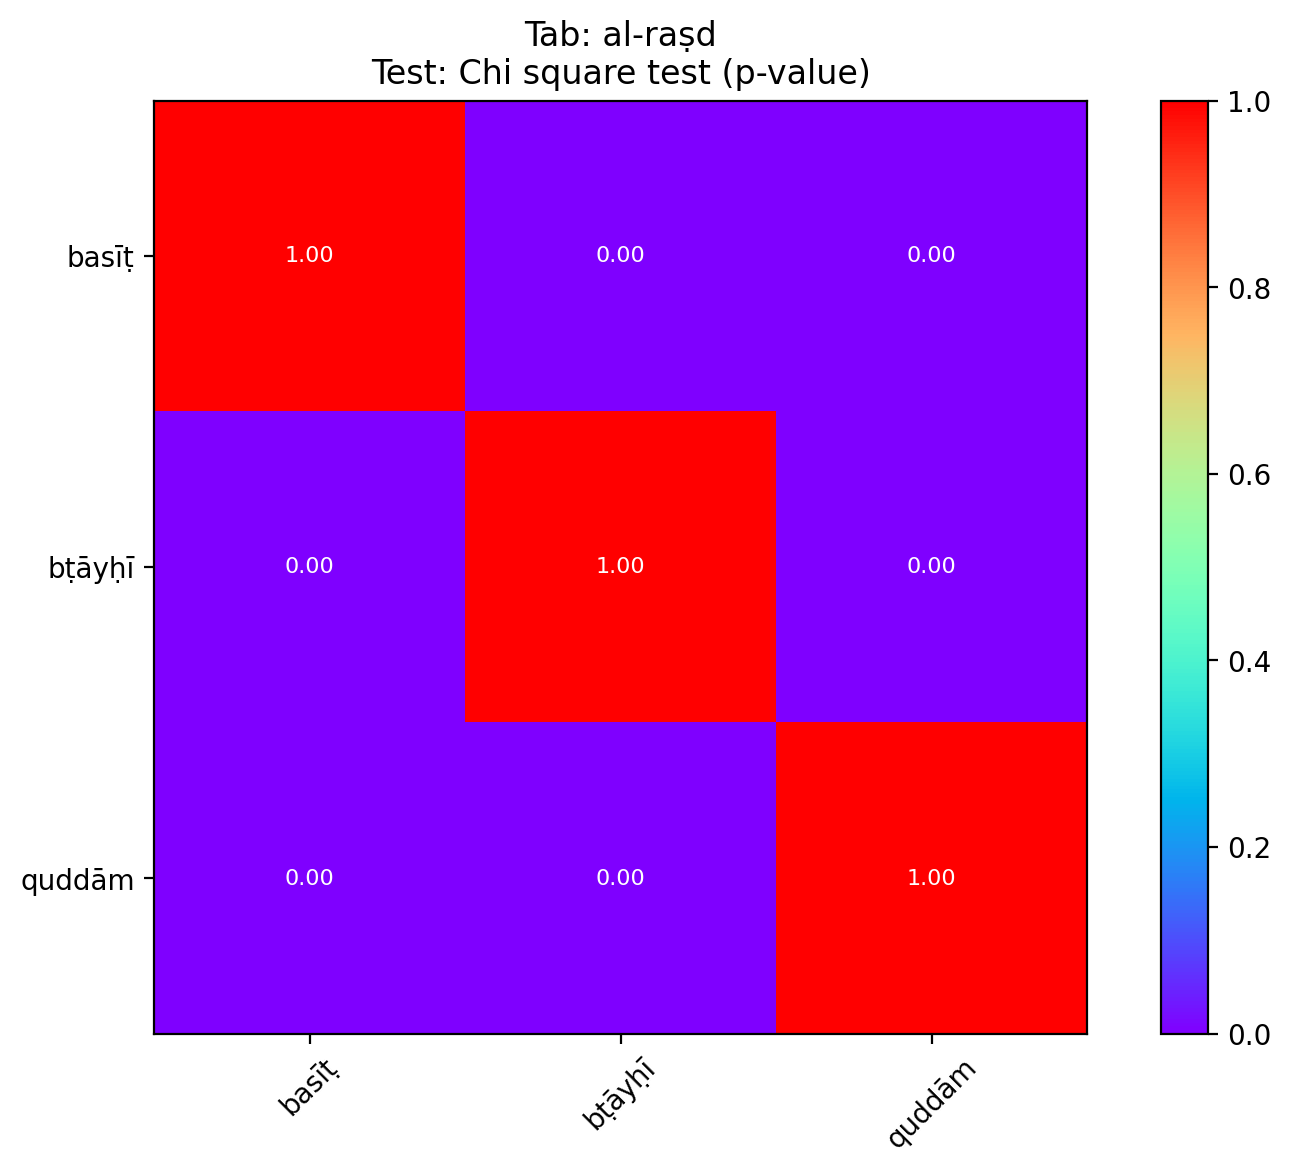

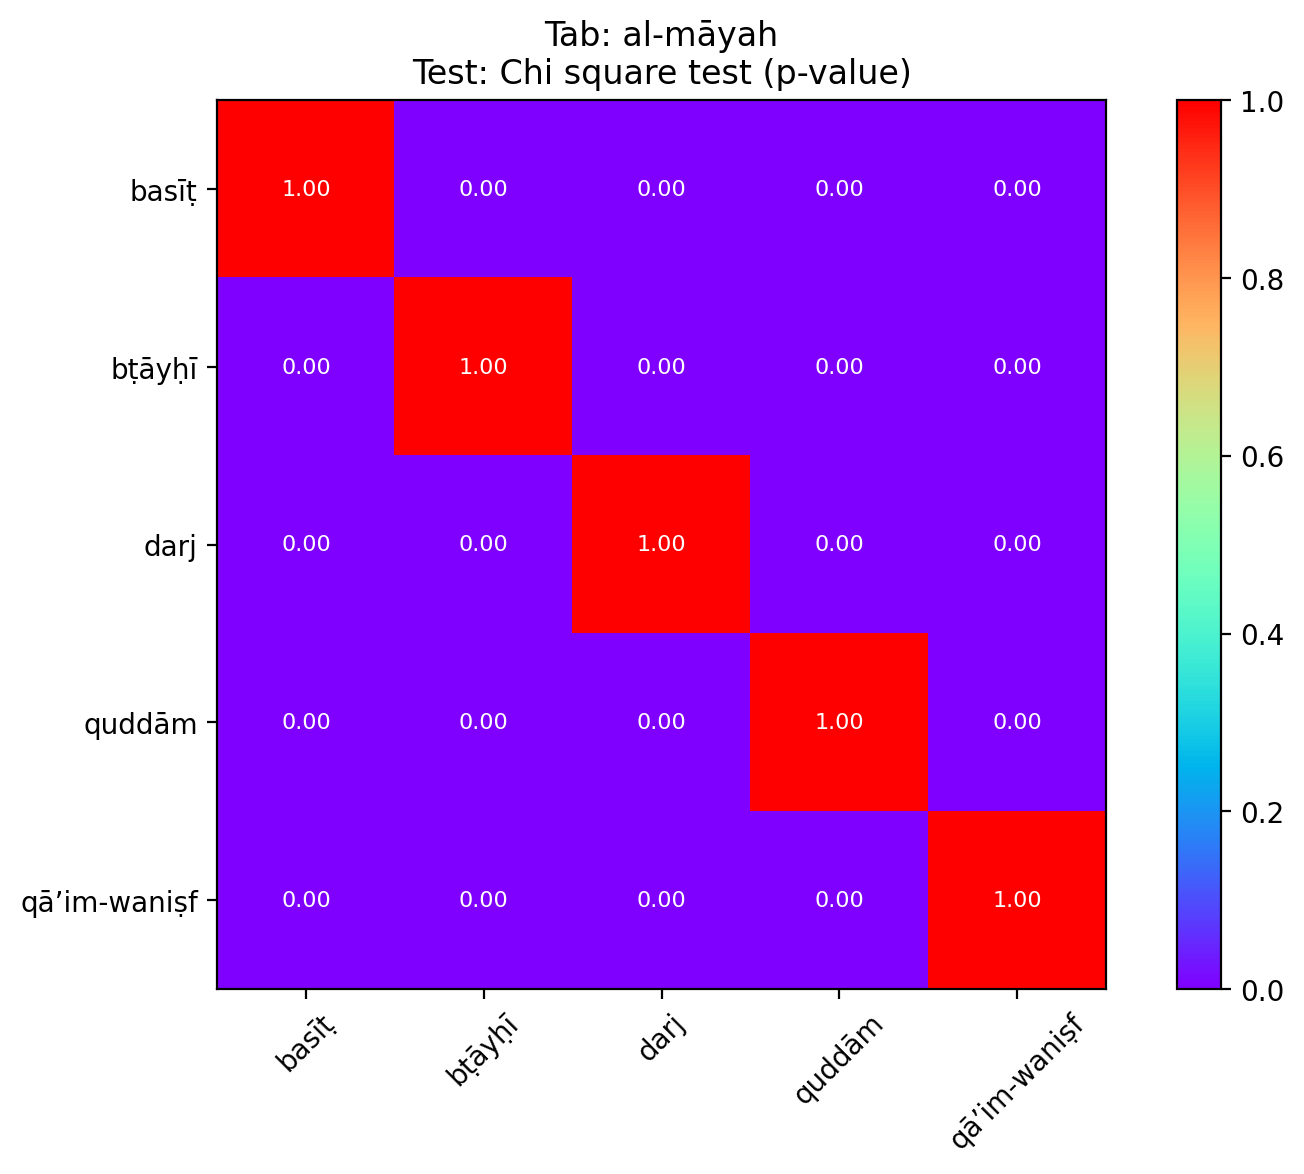

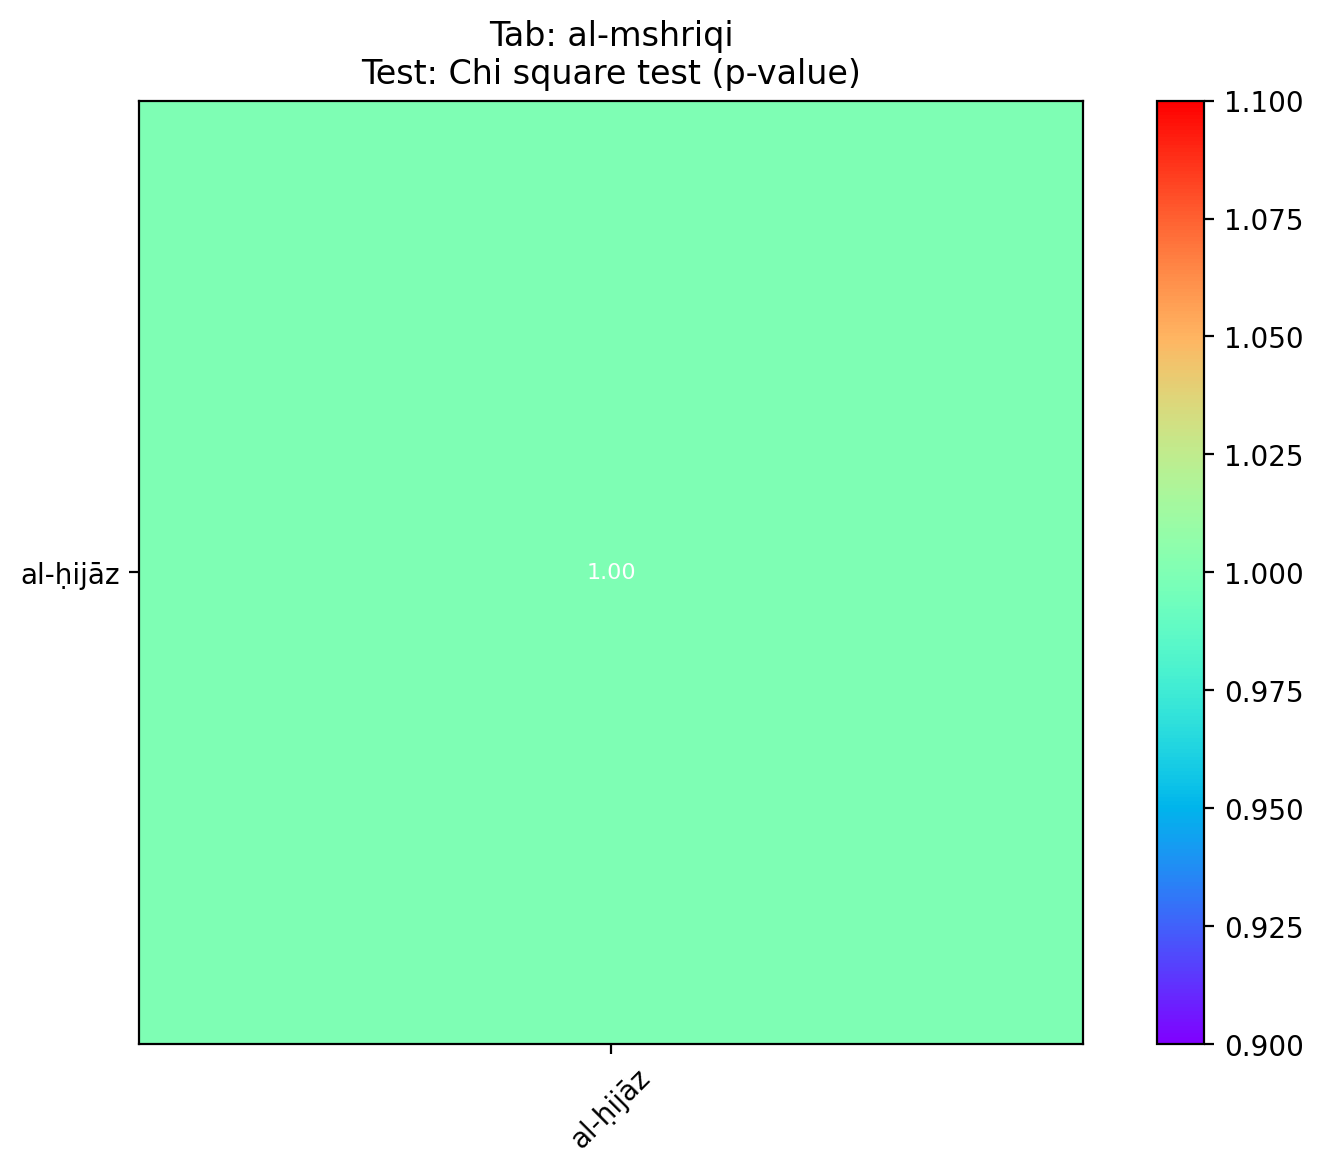

NEW TEST ---------------------------------------------------------------------------------


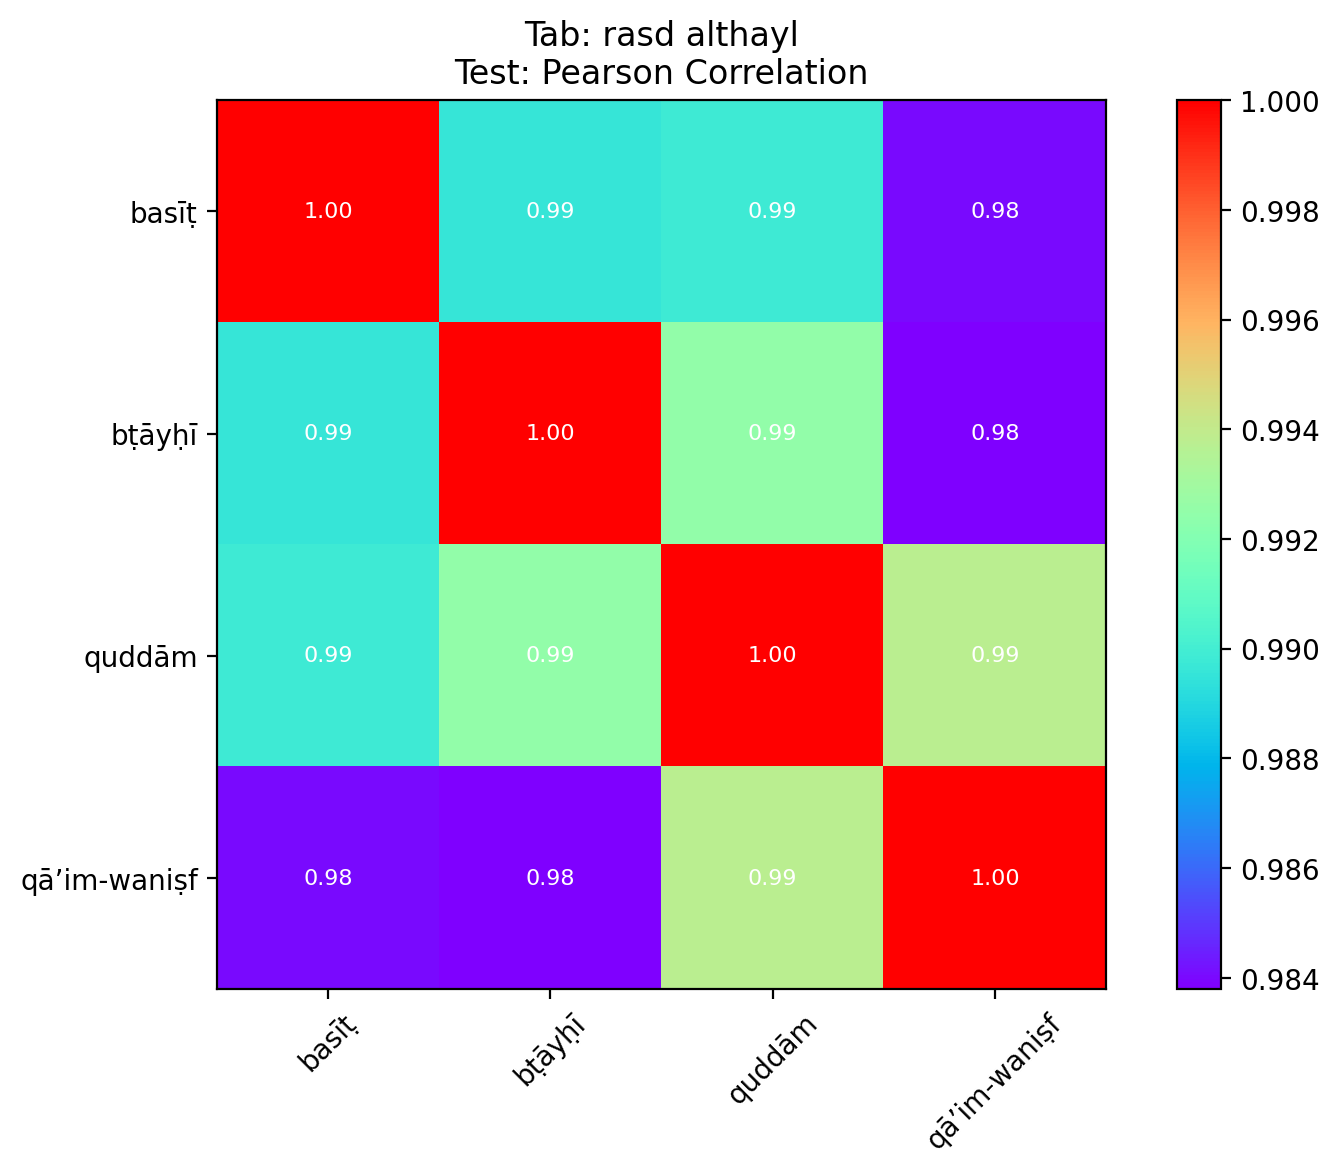

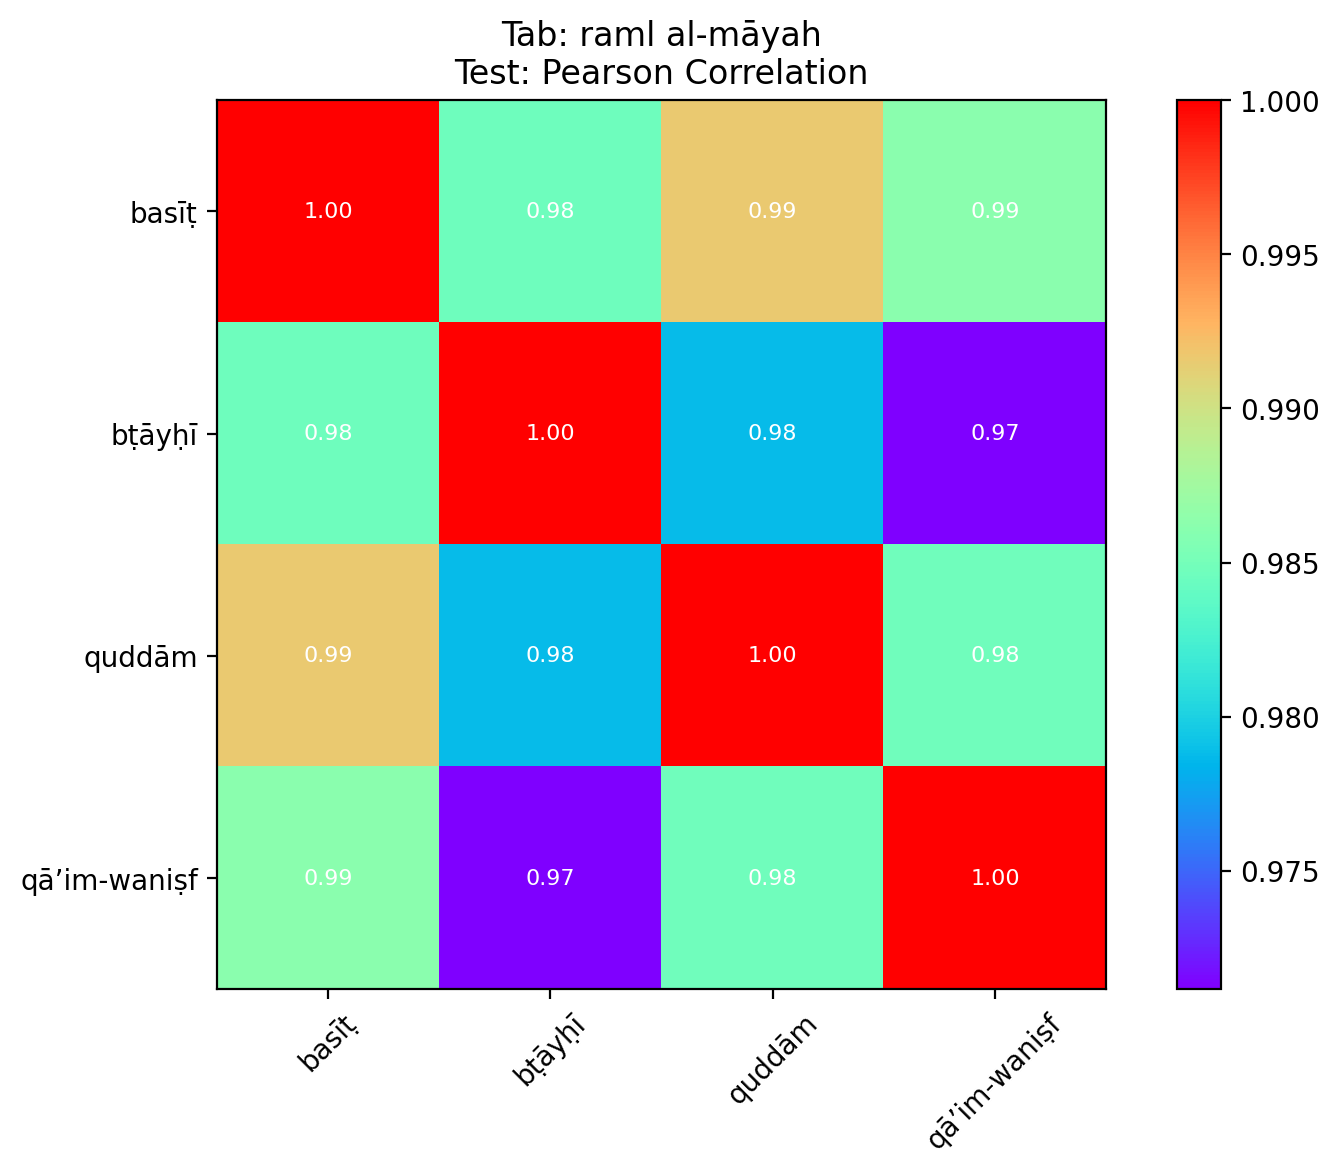

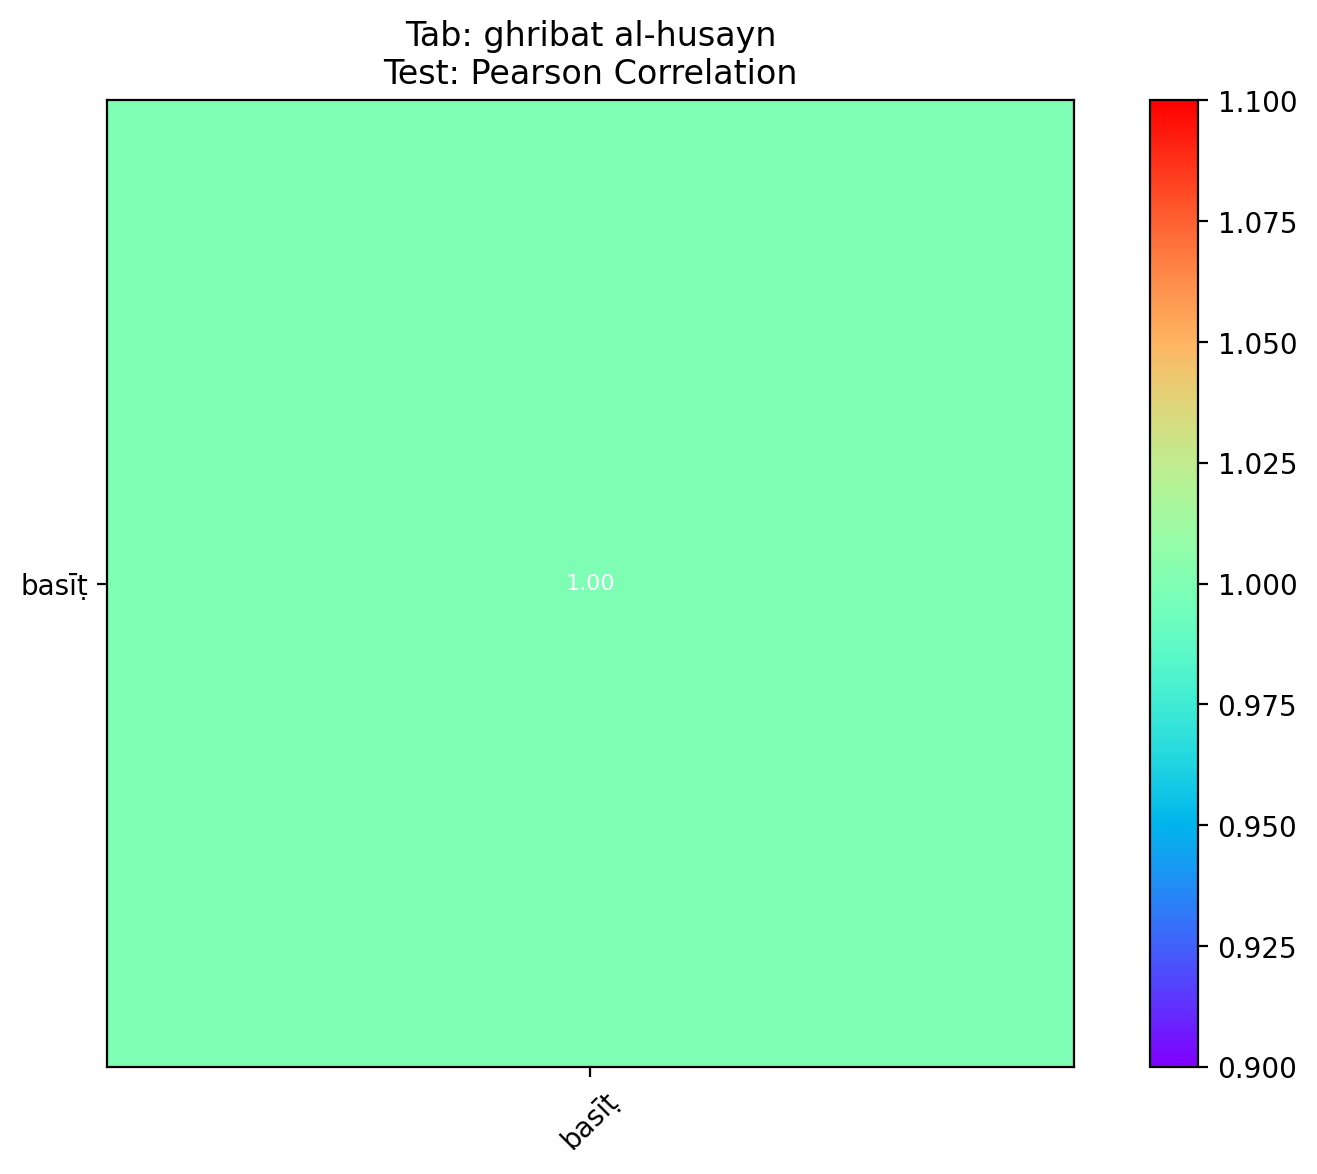

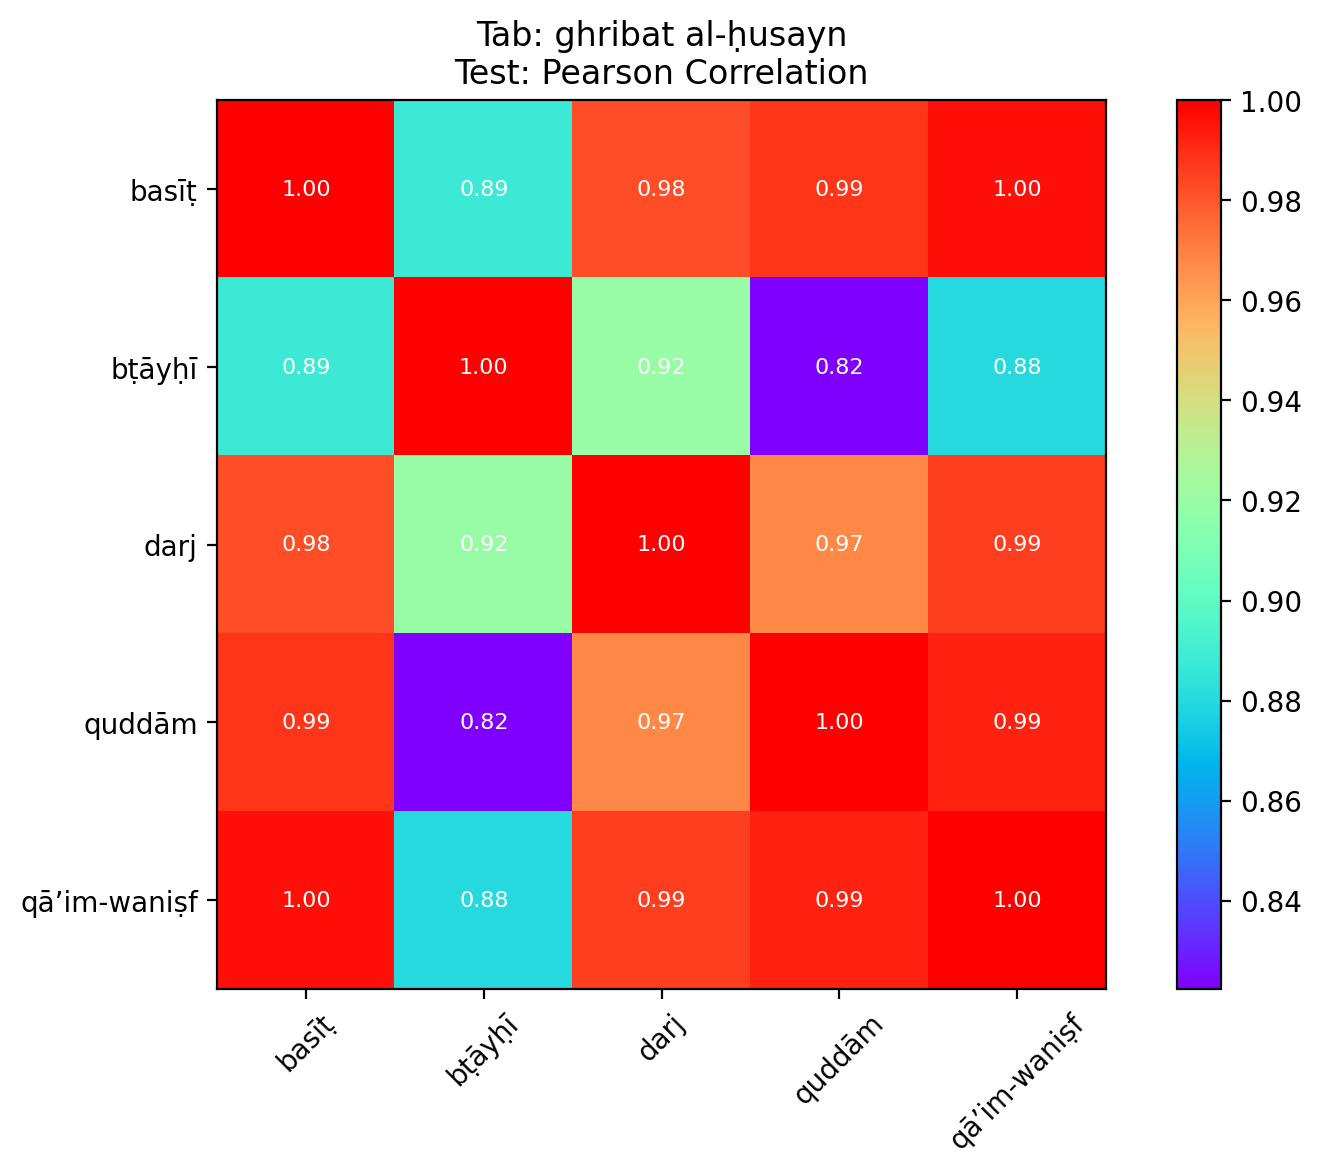

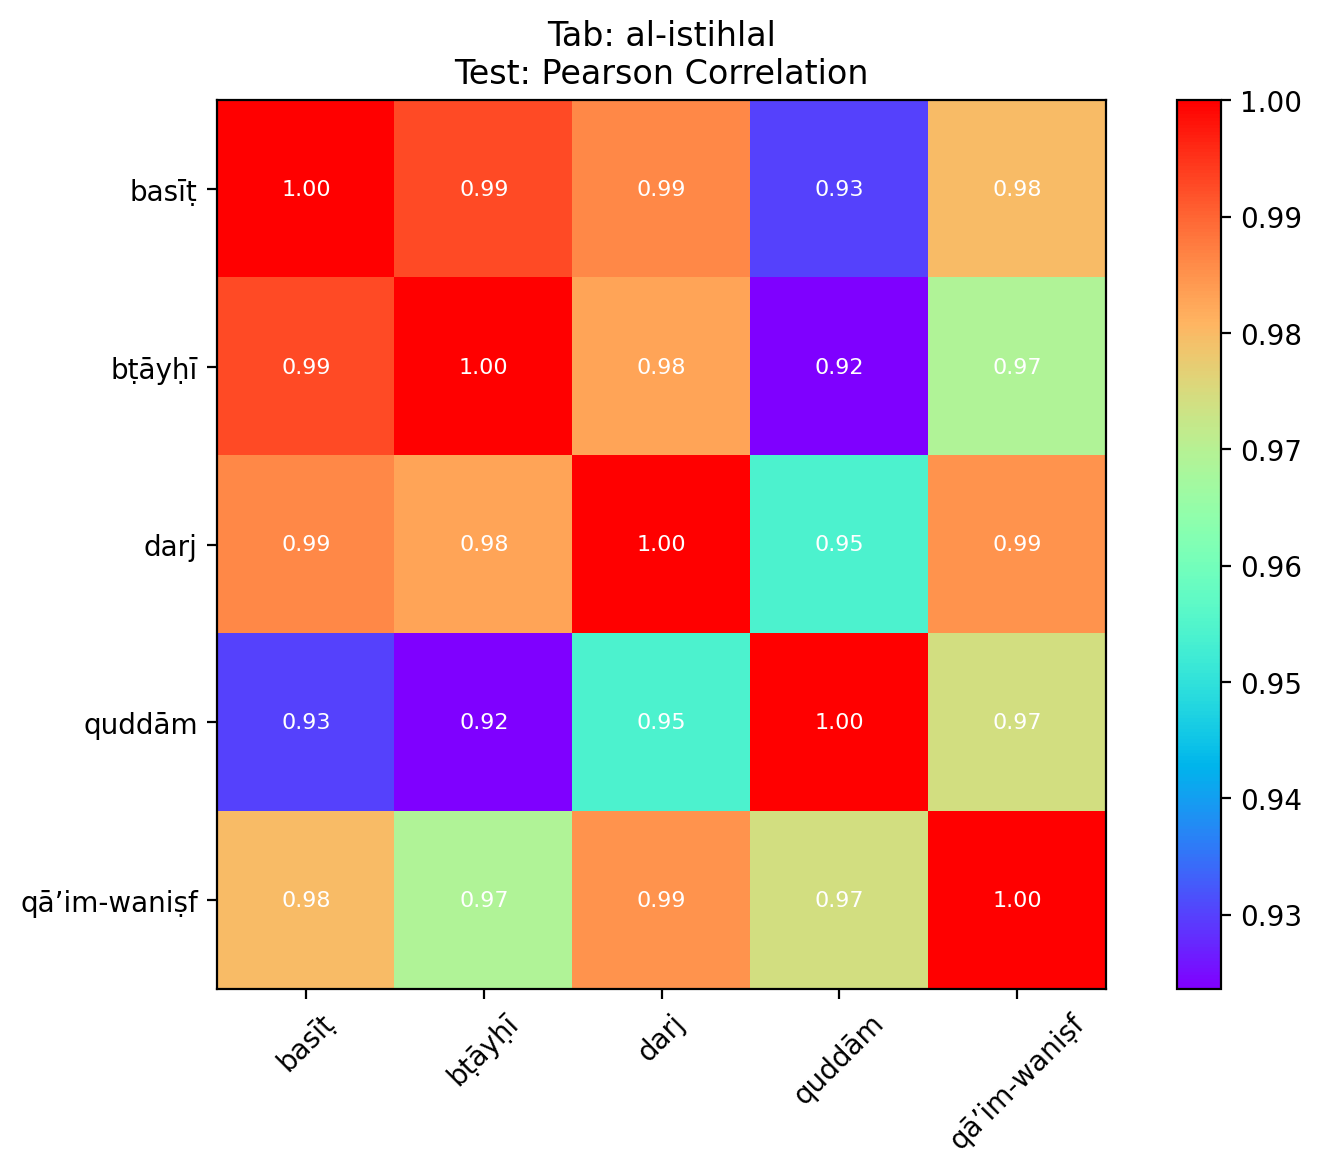

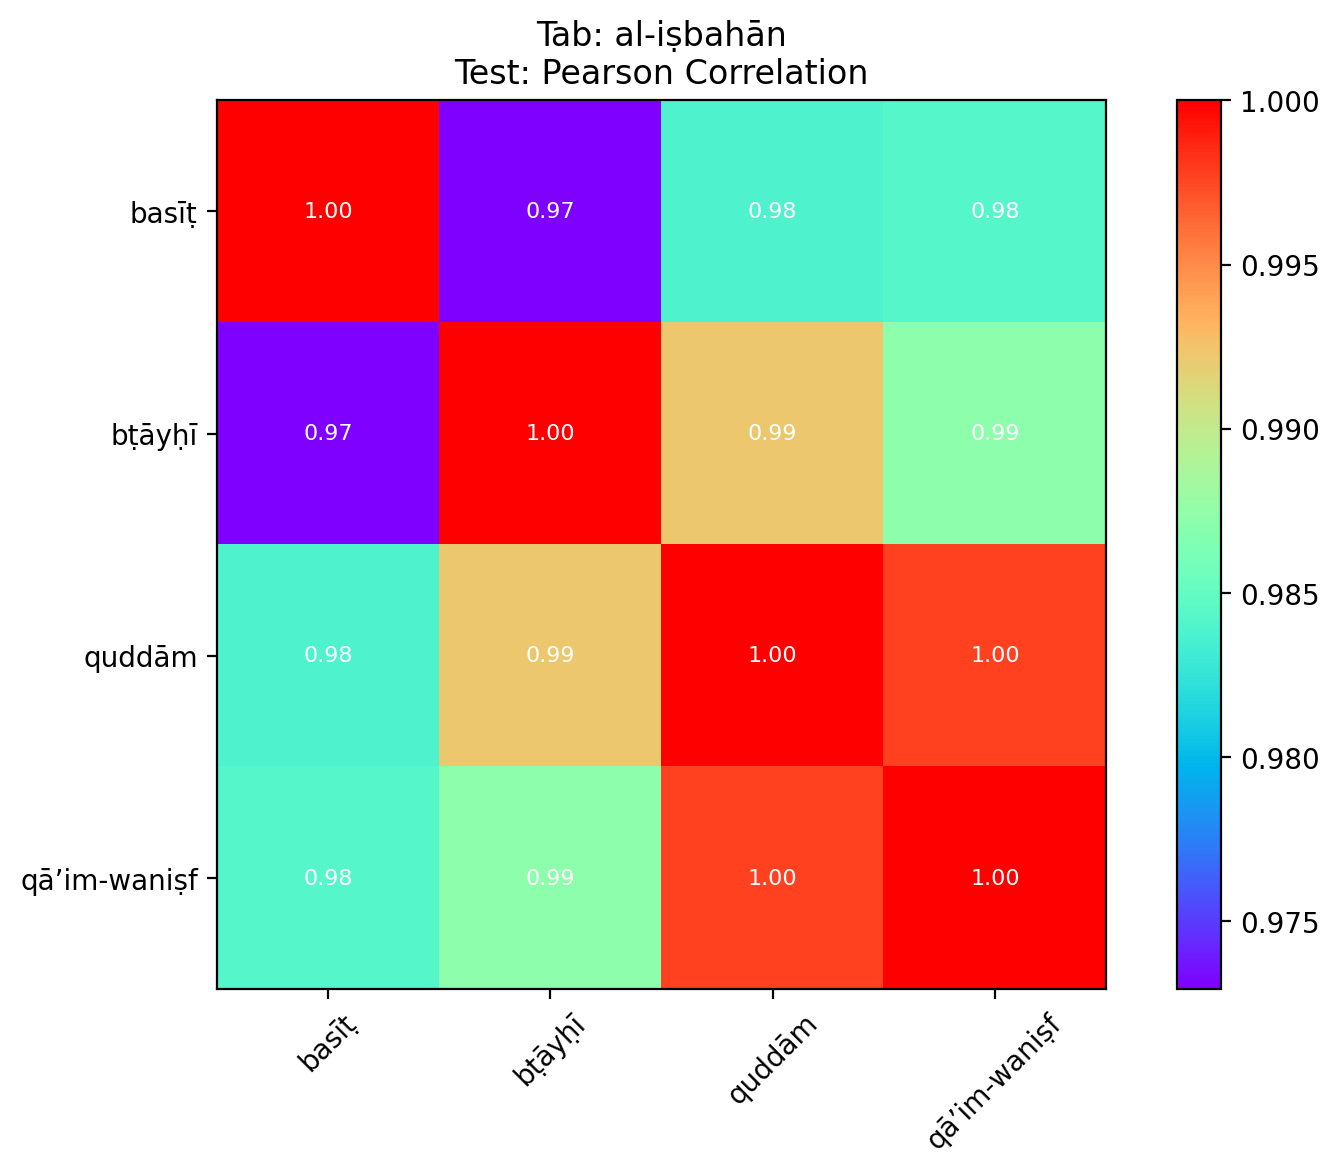

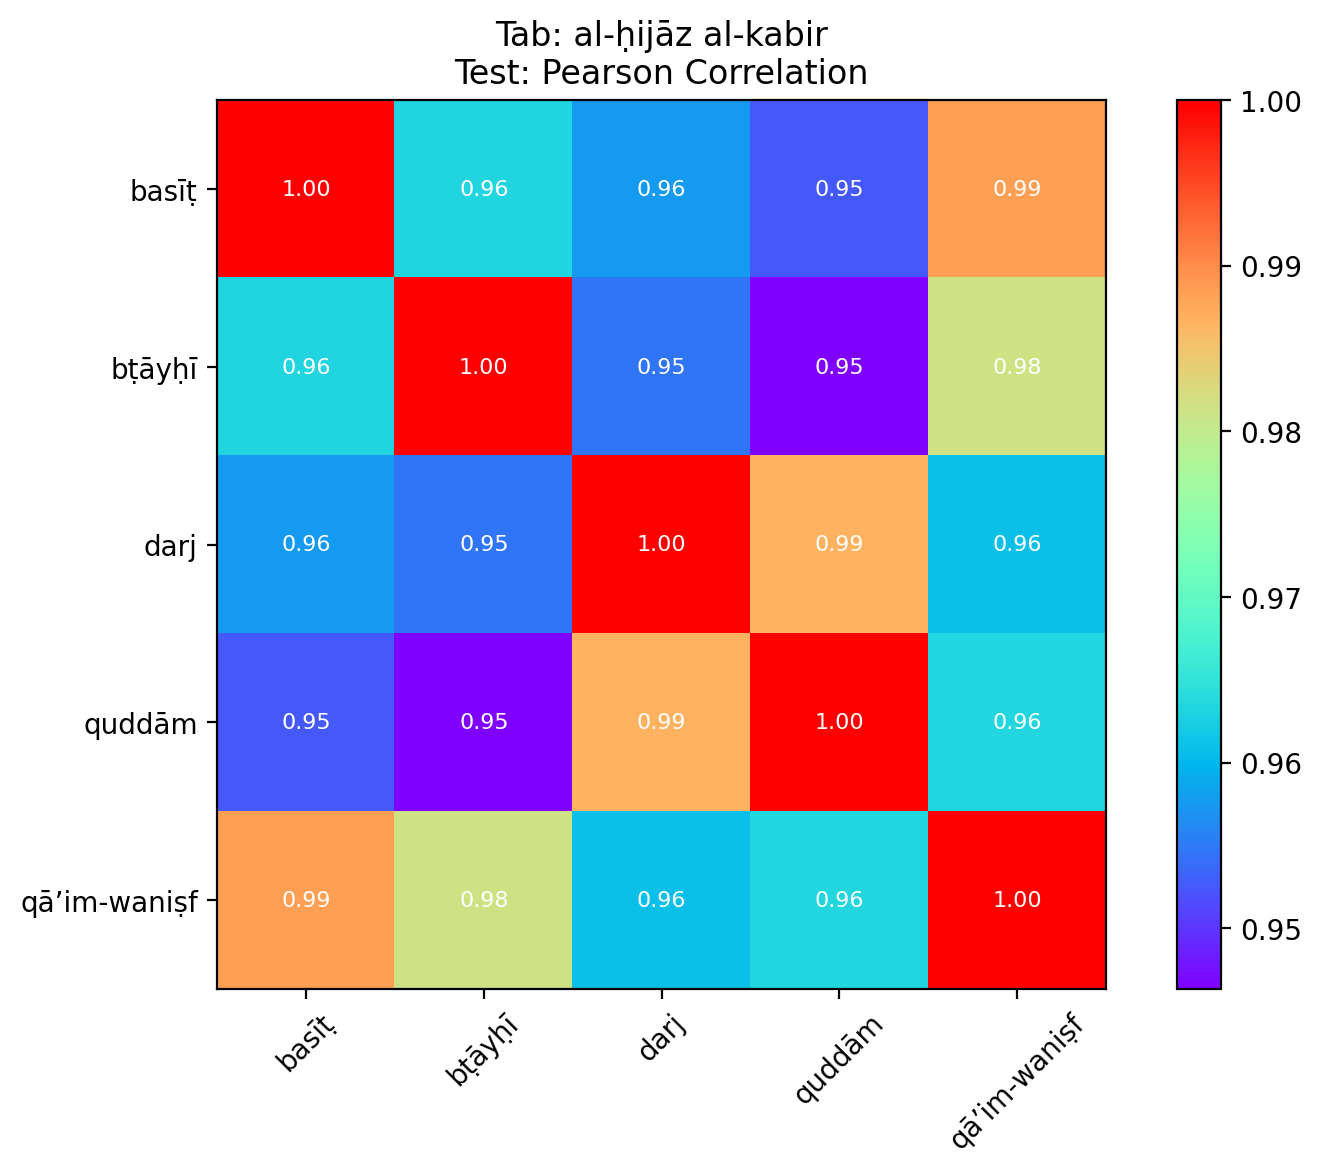

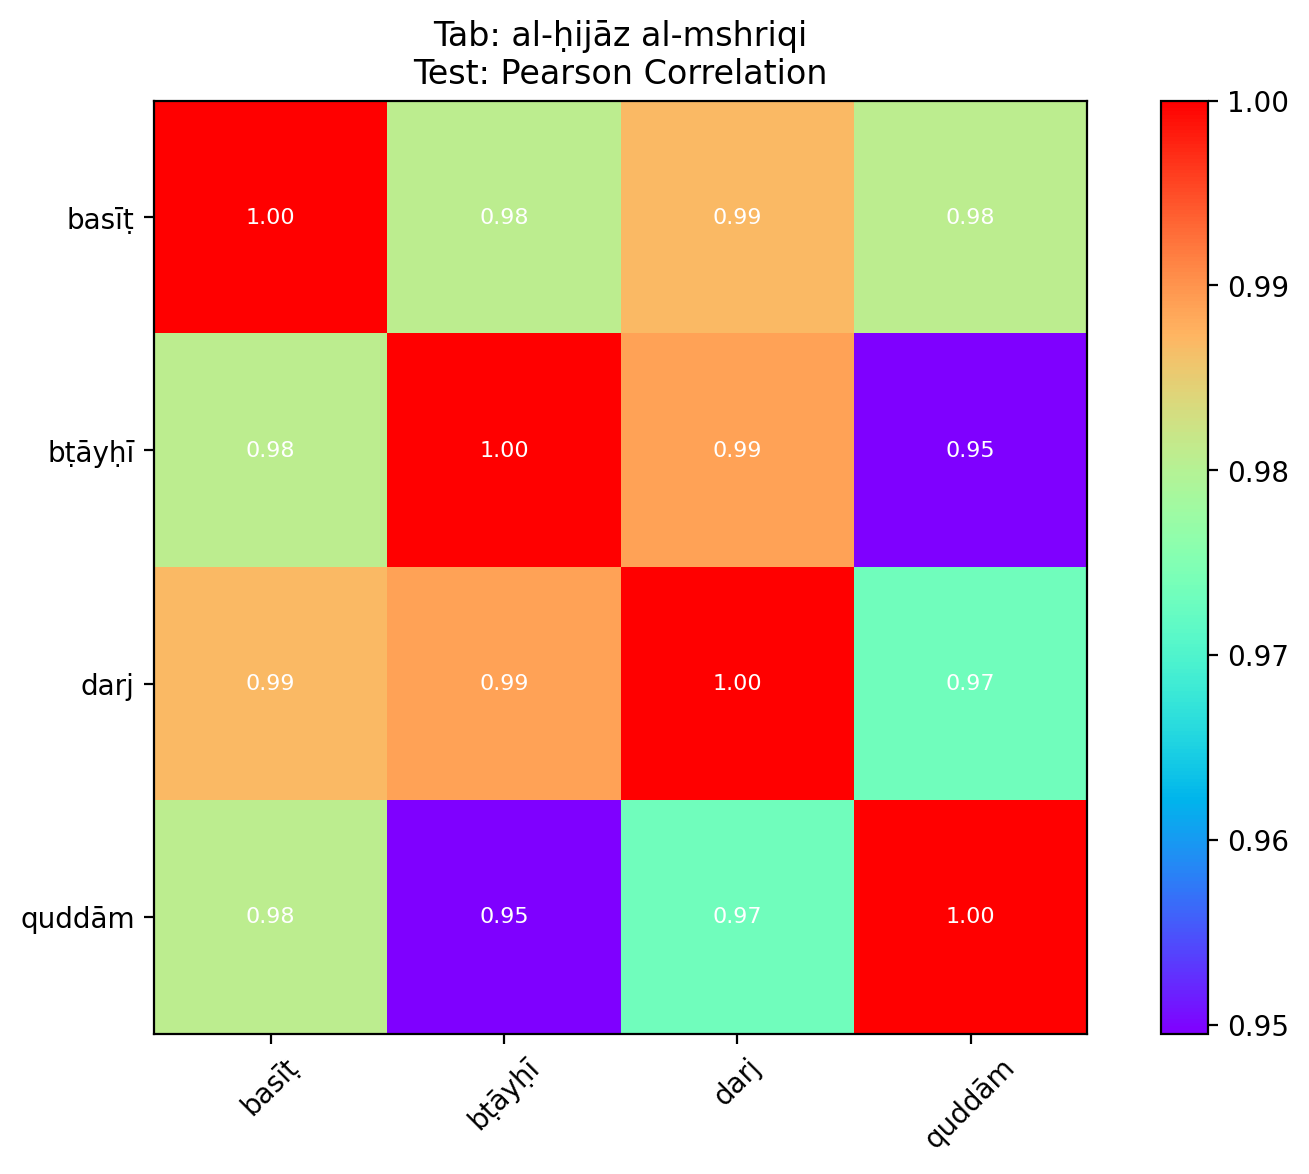

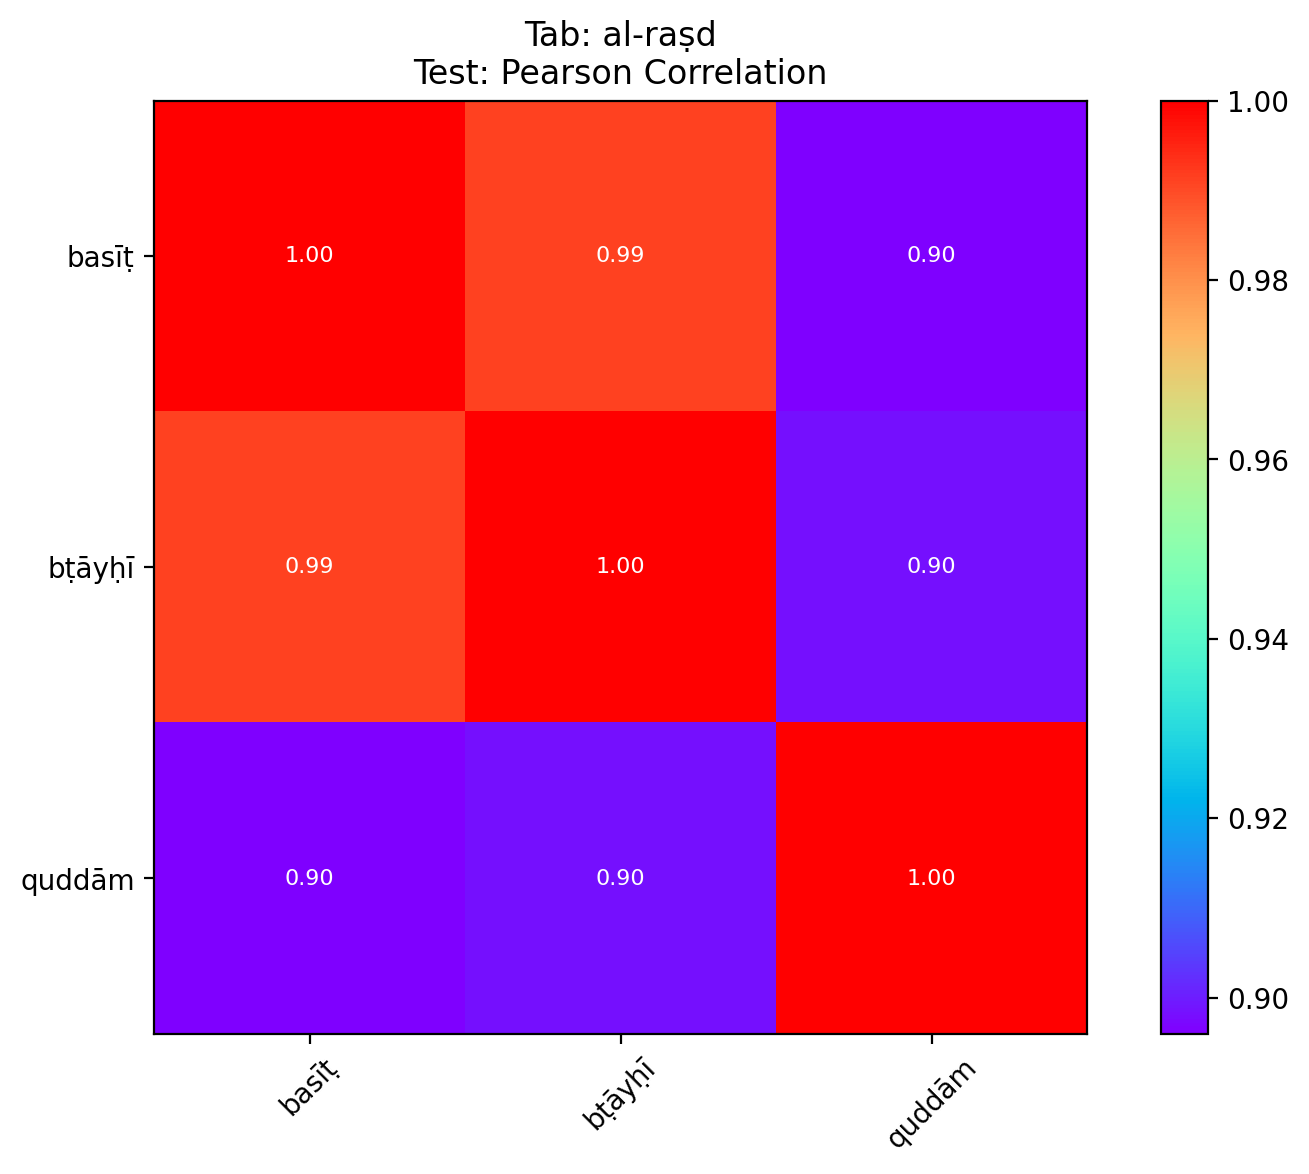

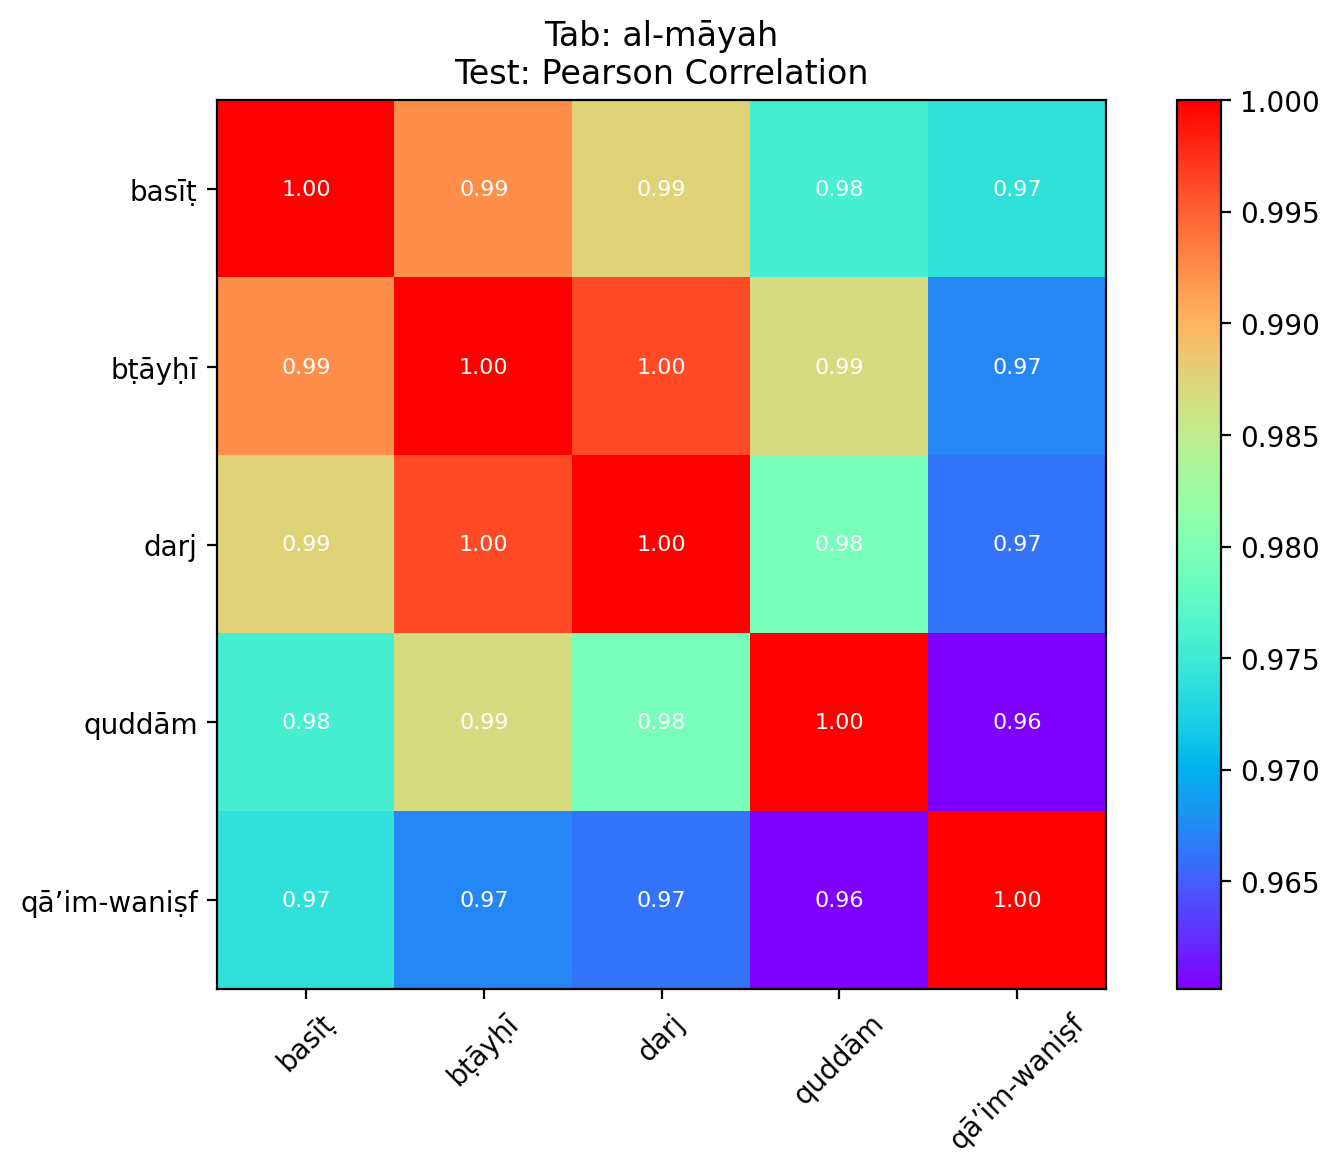

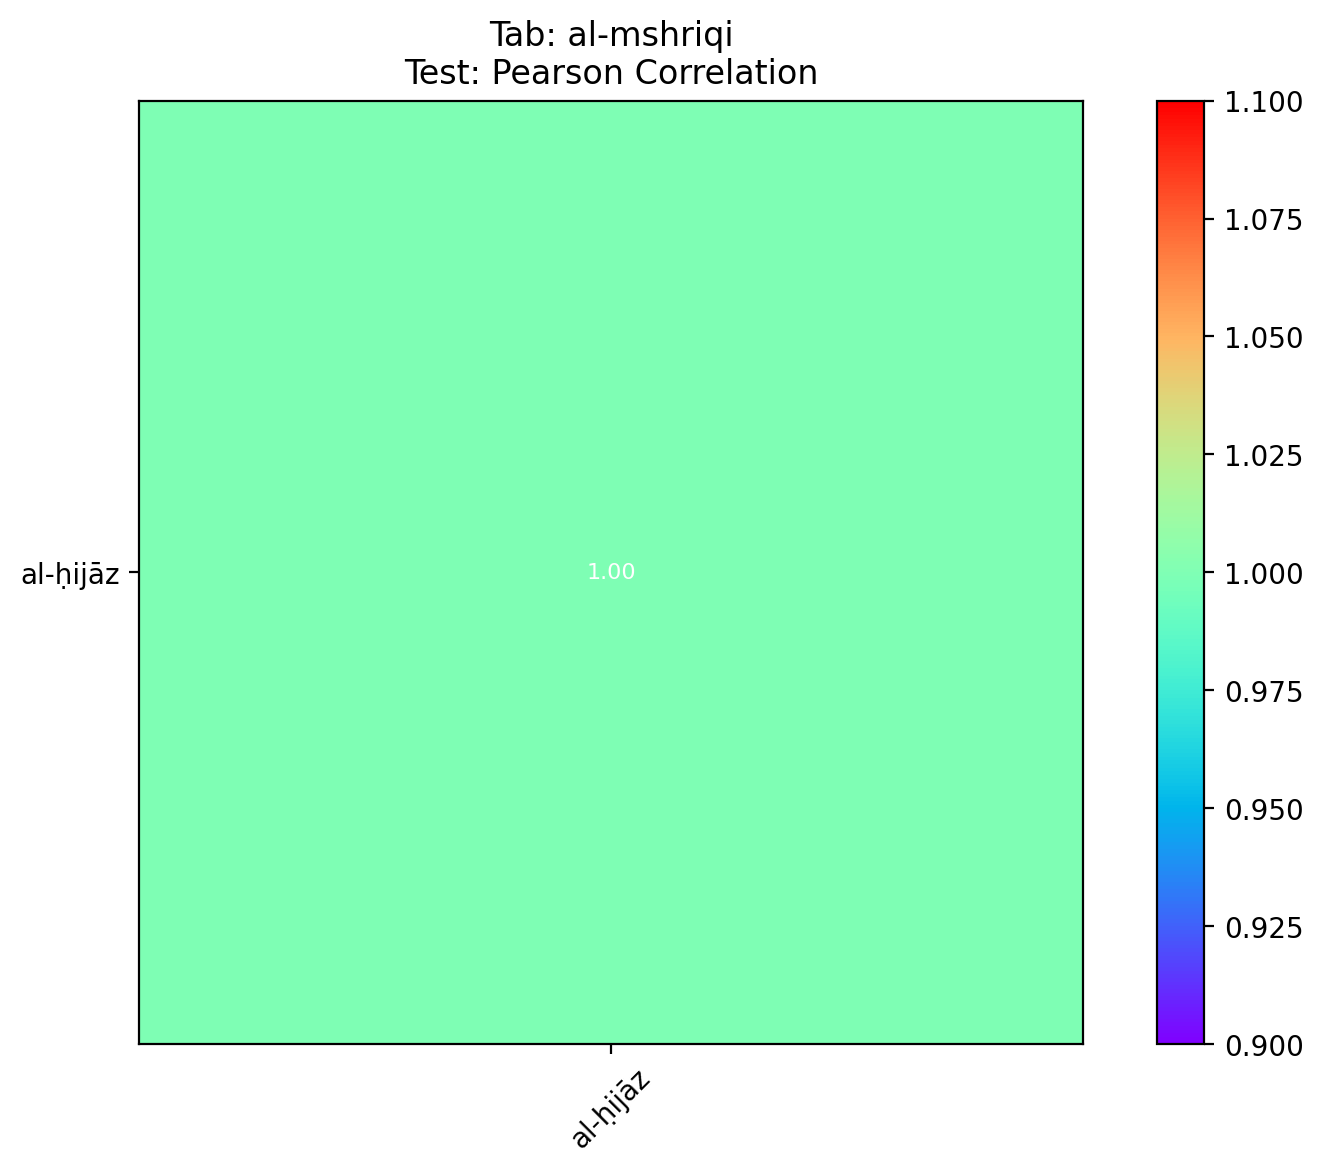

NEW TEST ---------------------------------------------------------------------------------


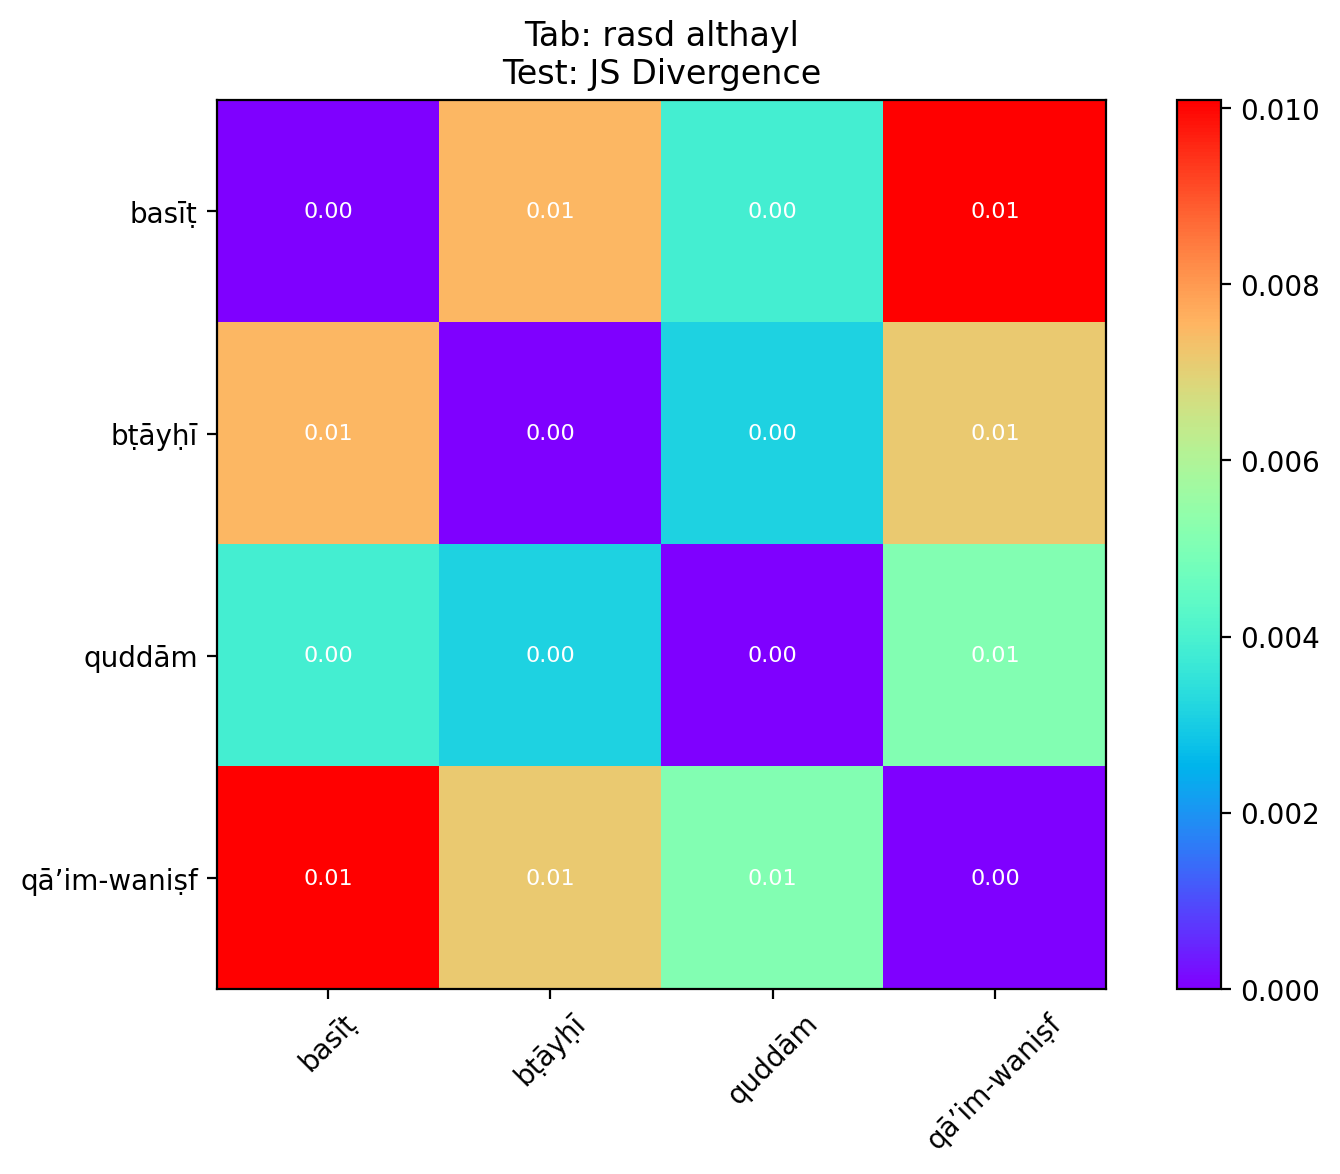

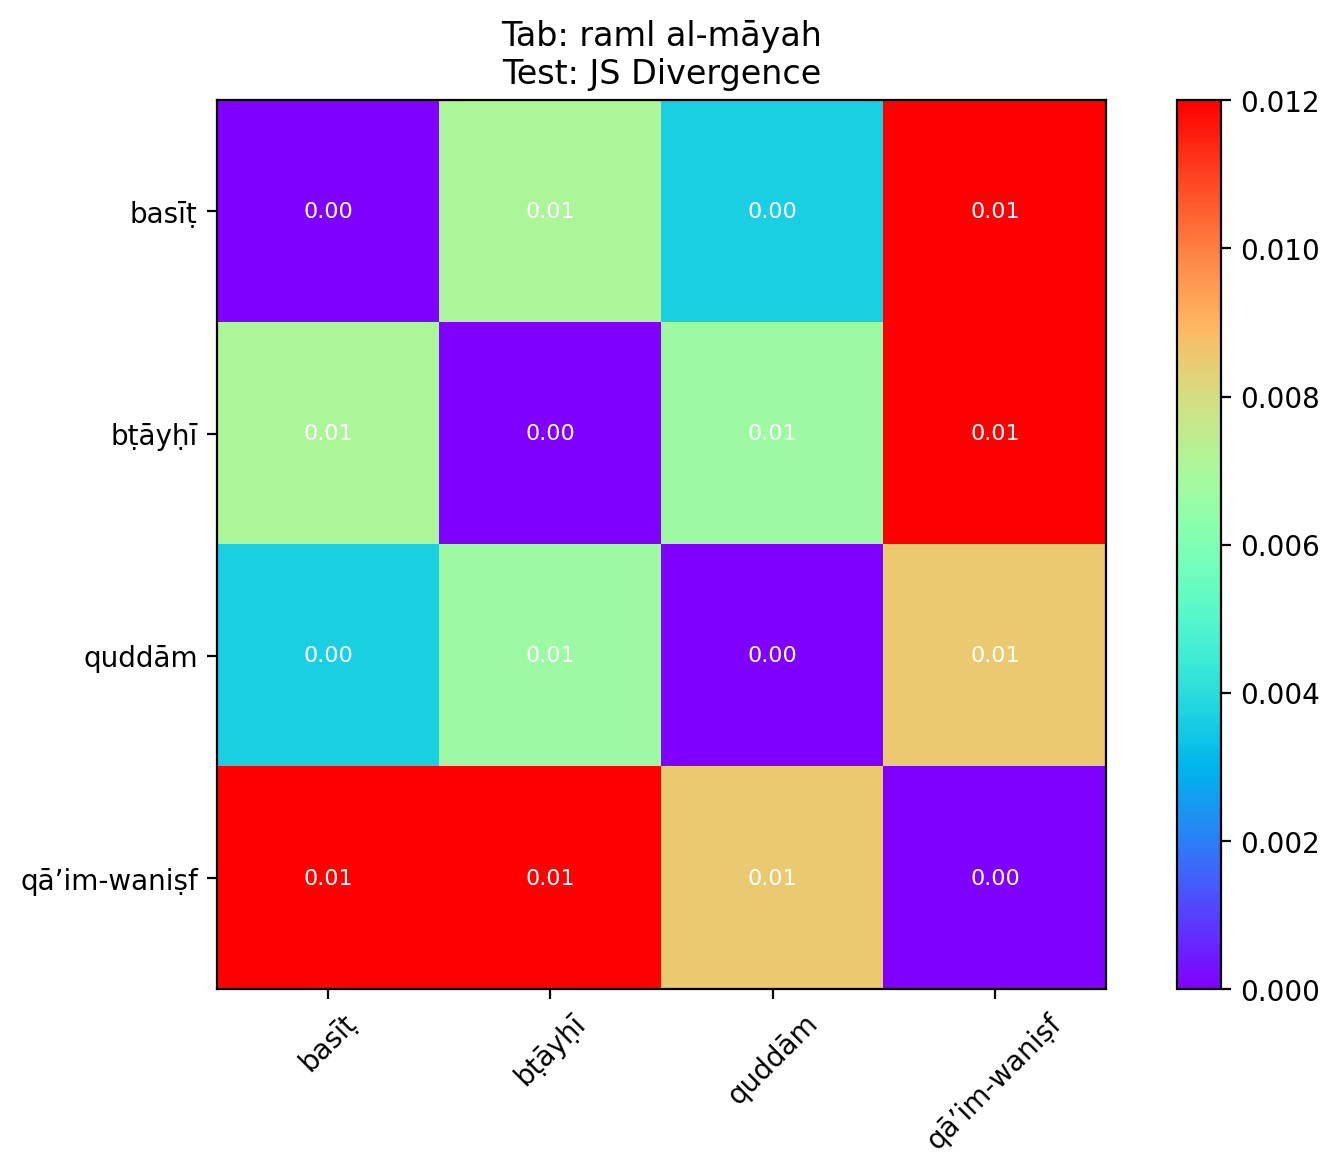

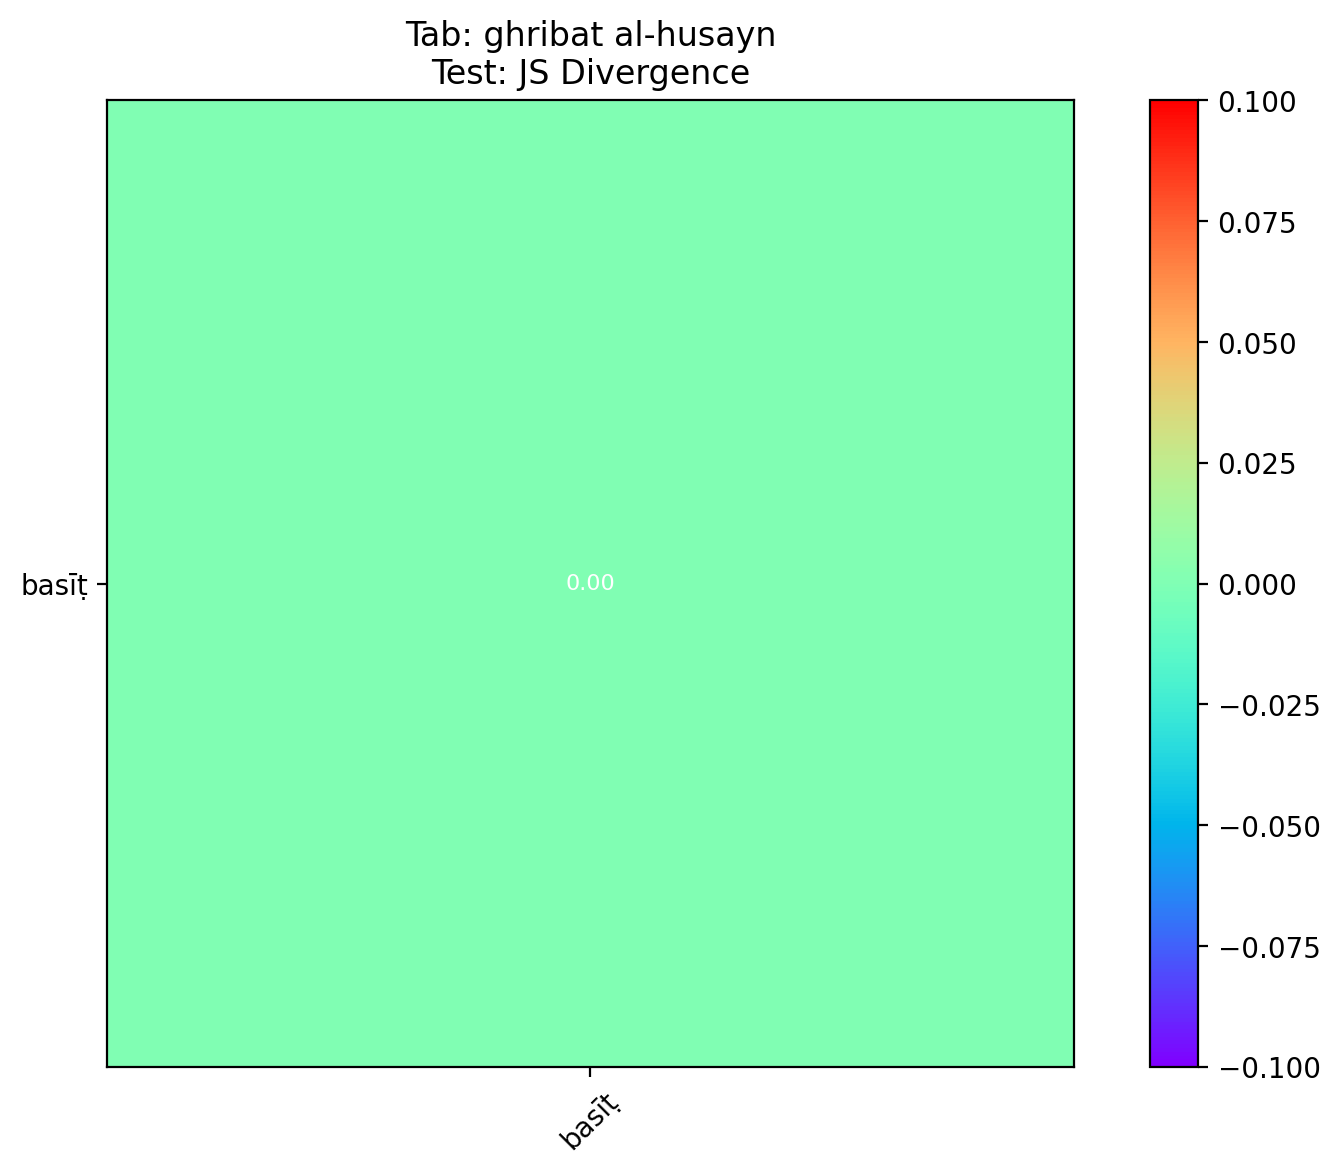

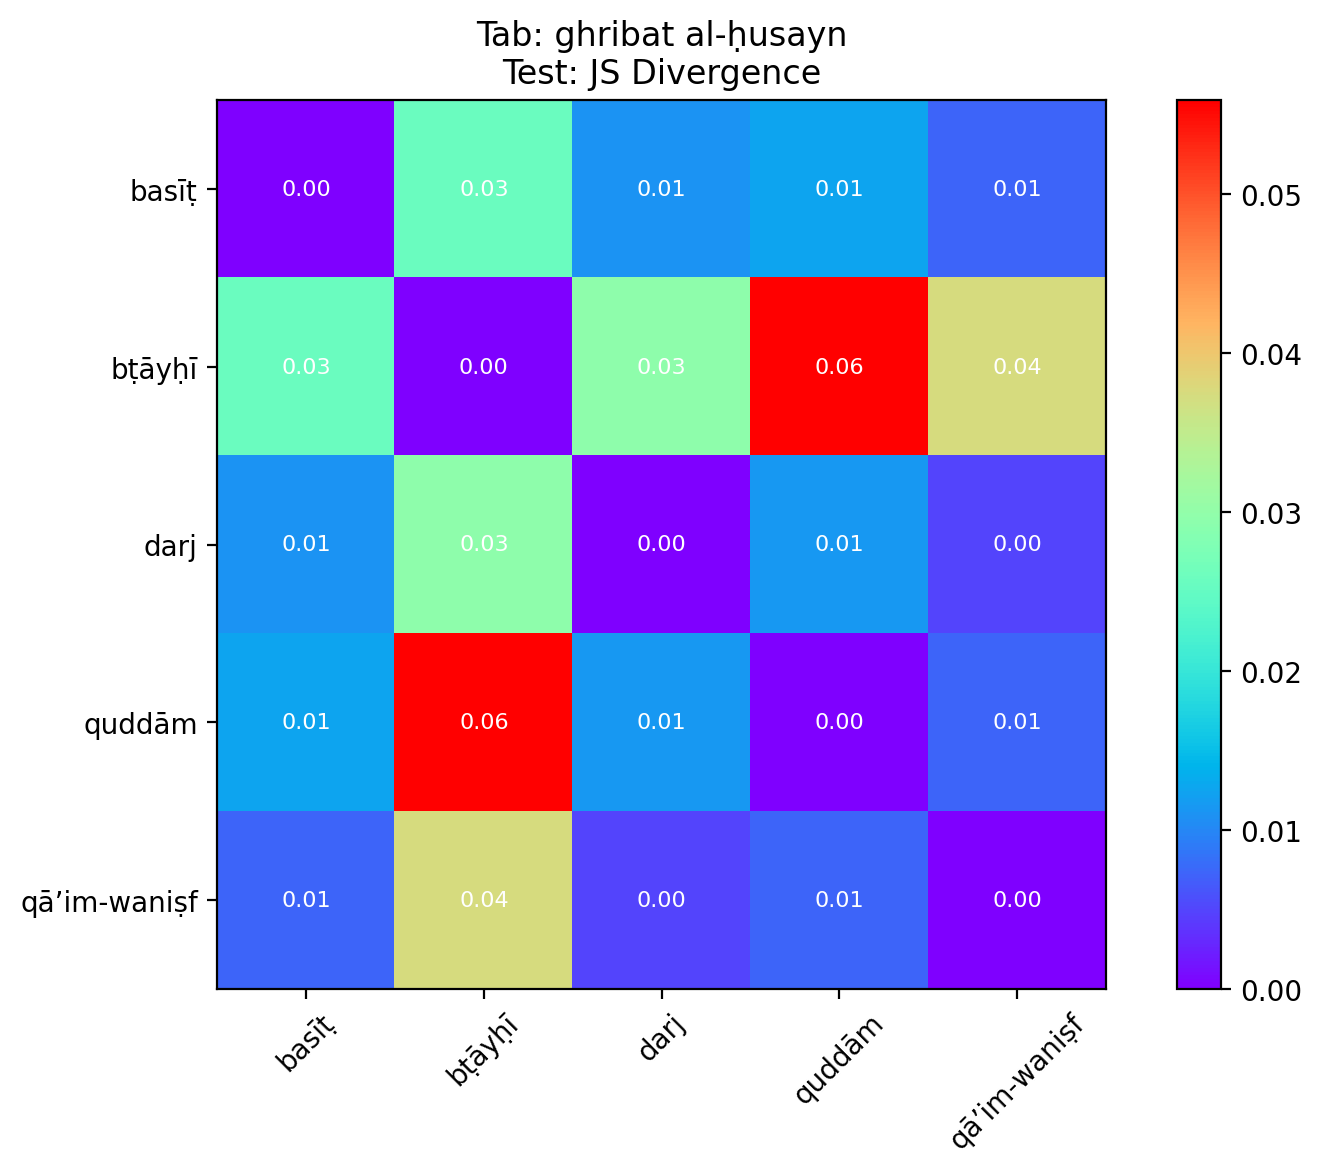

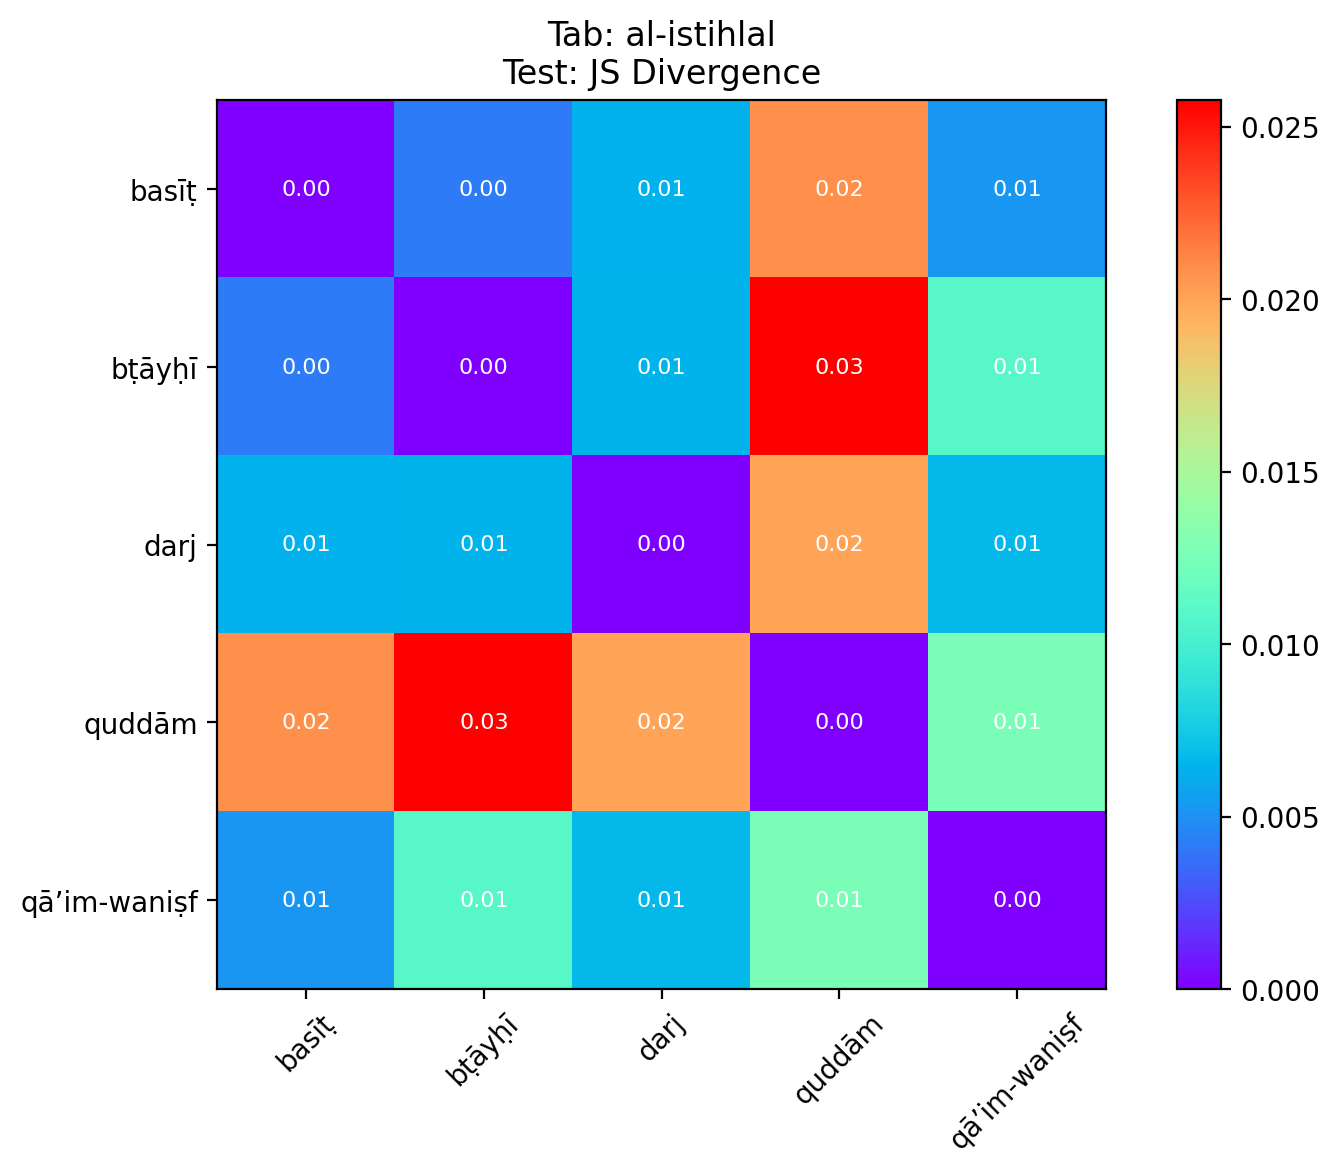

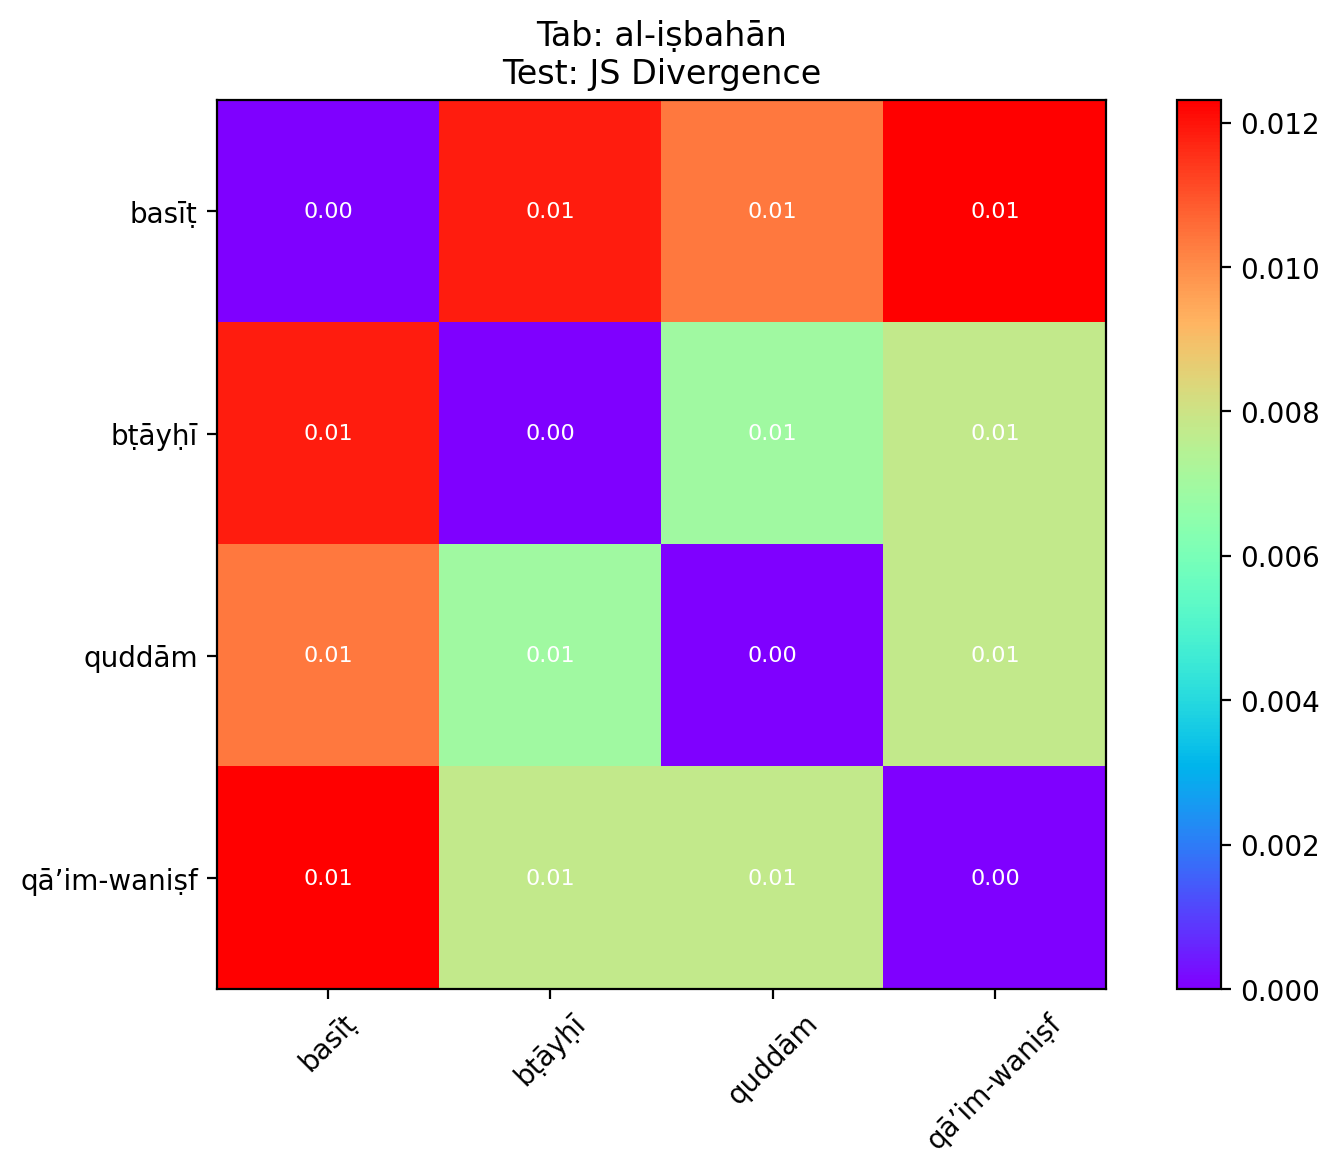

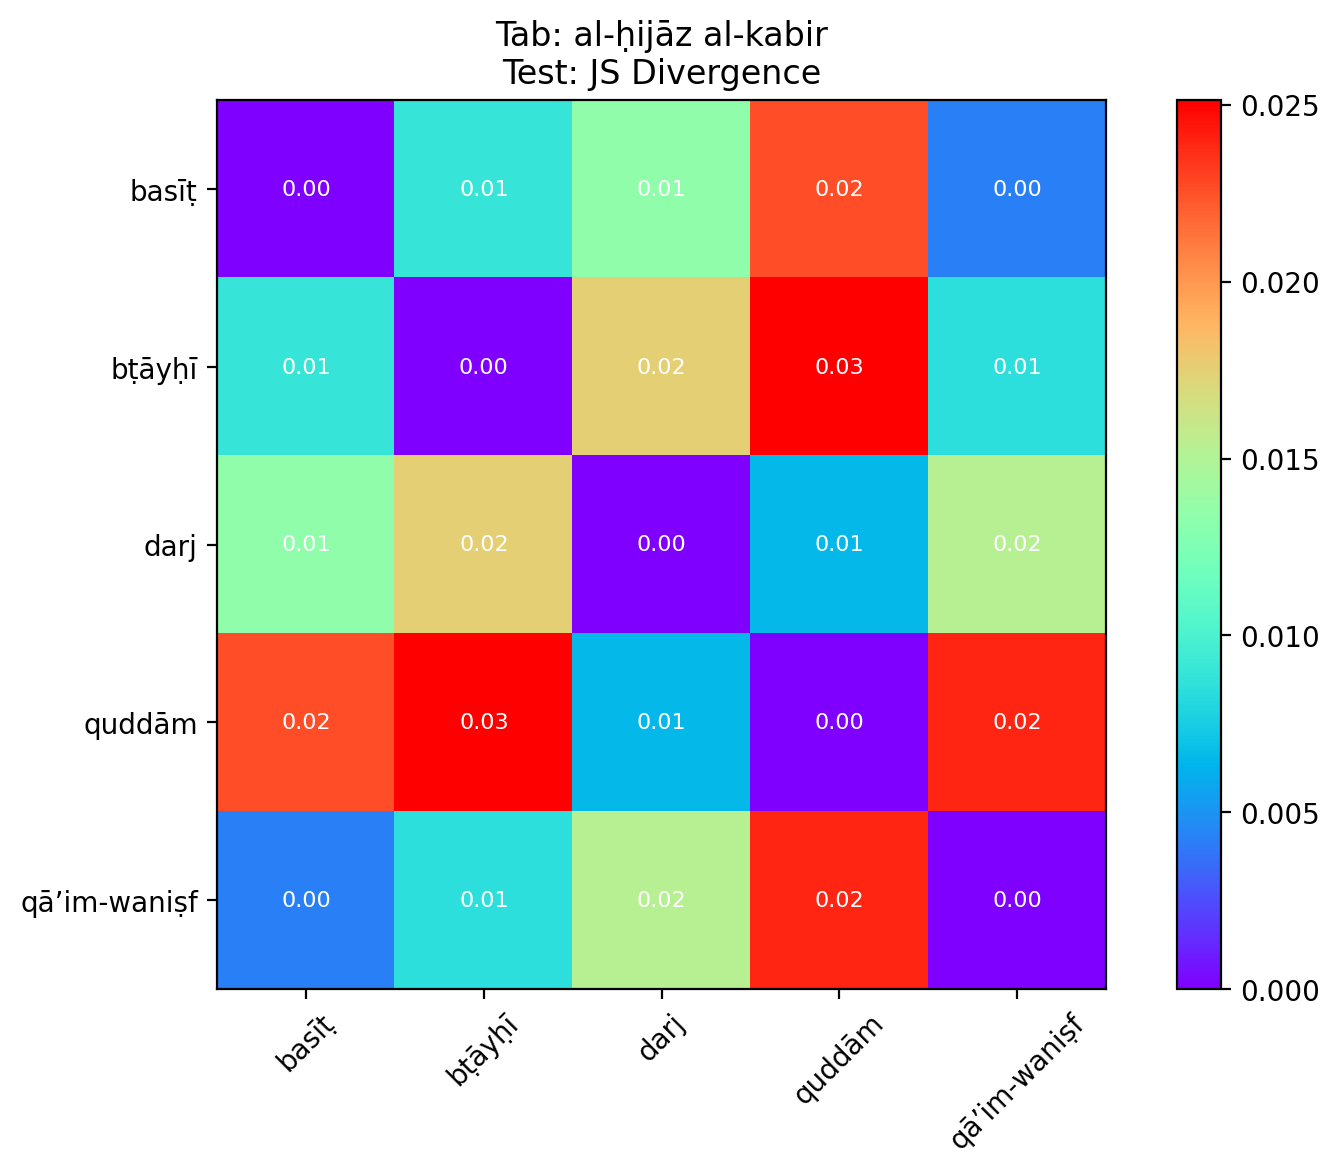

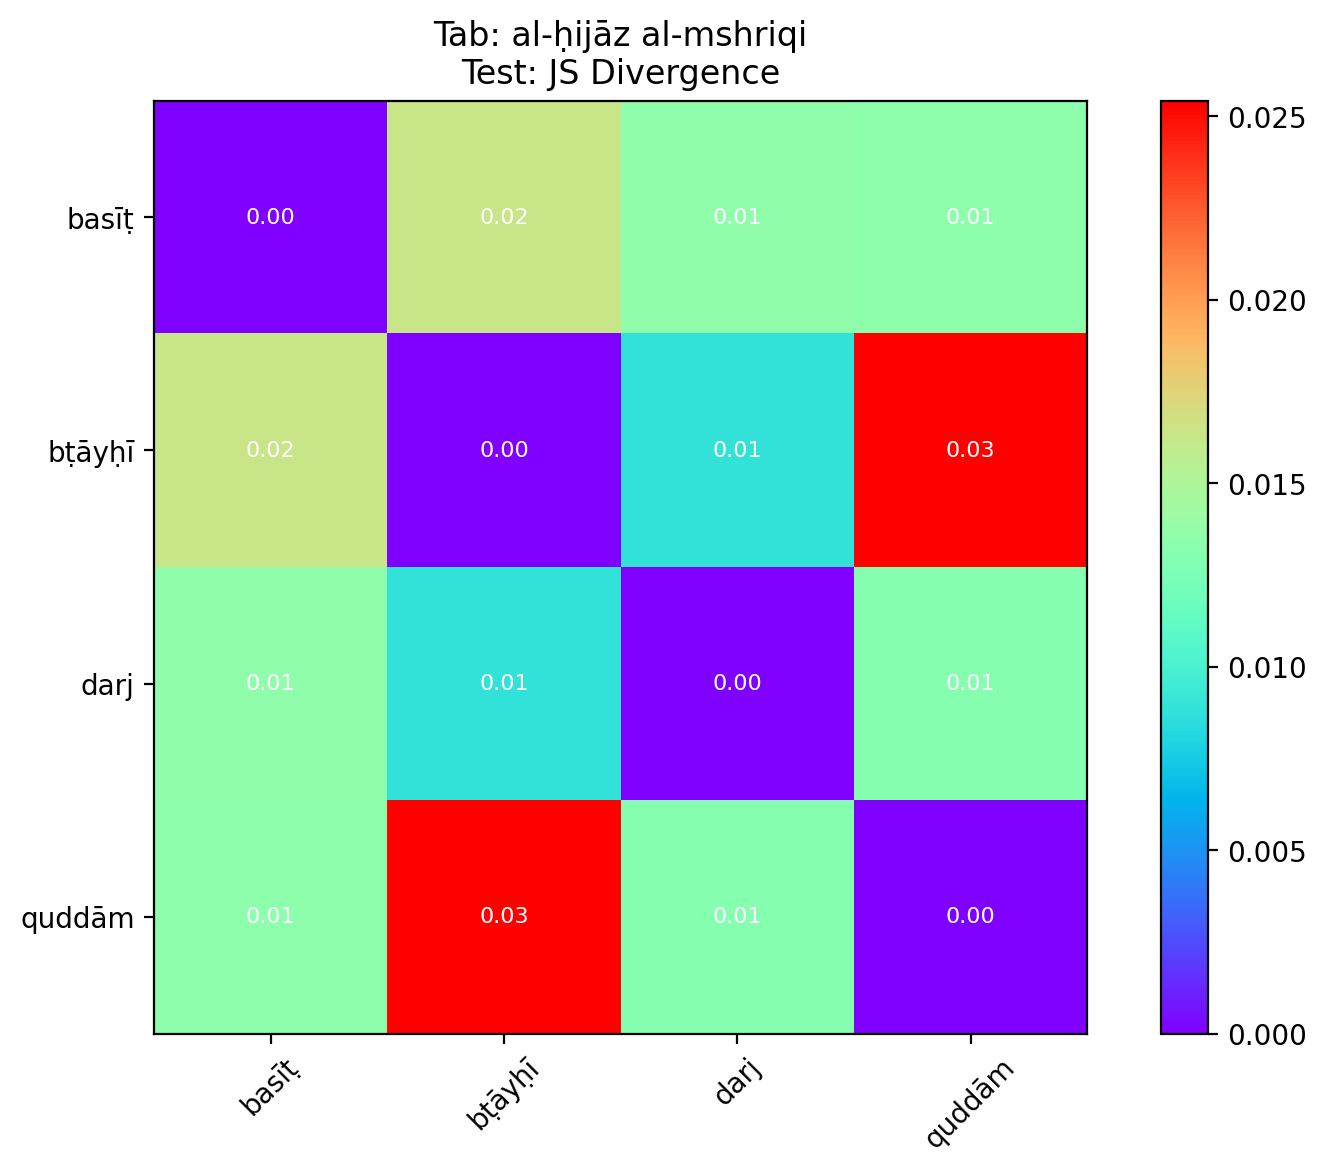

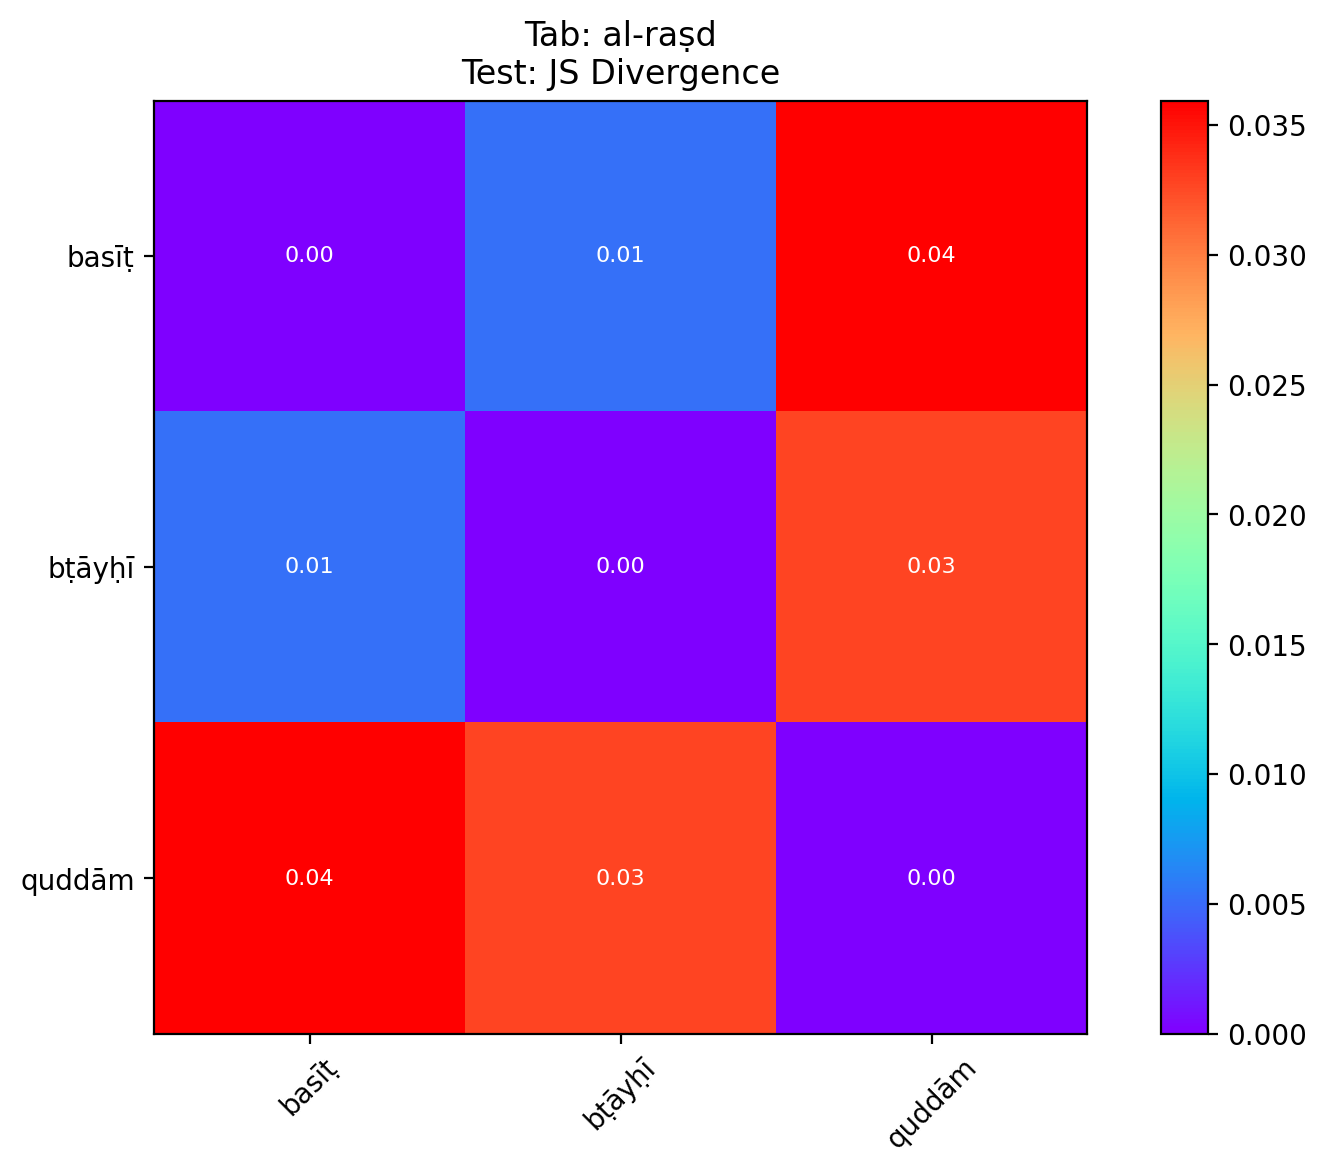

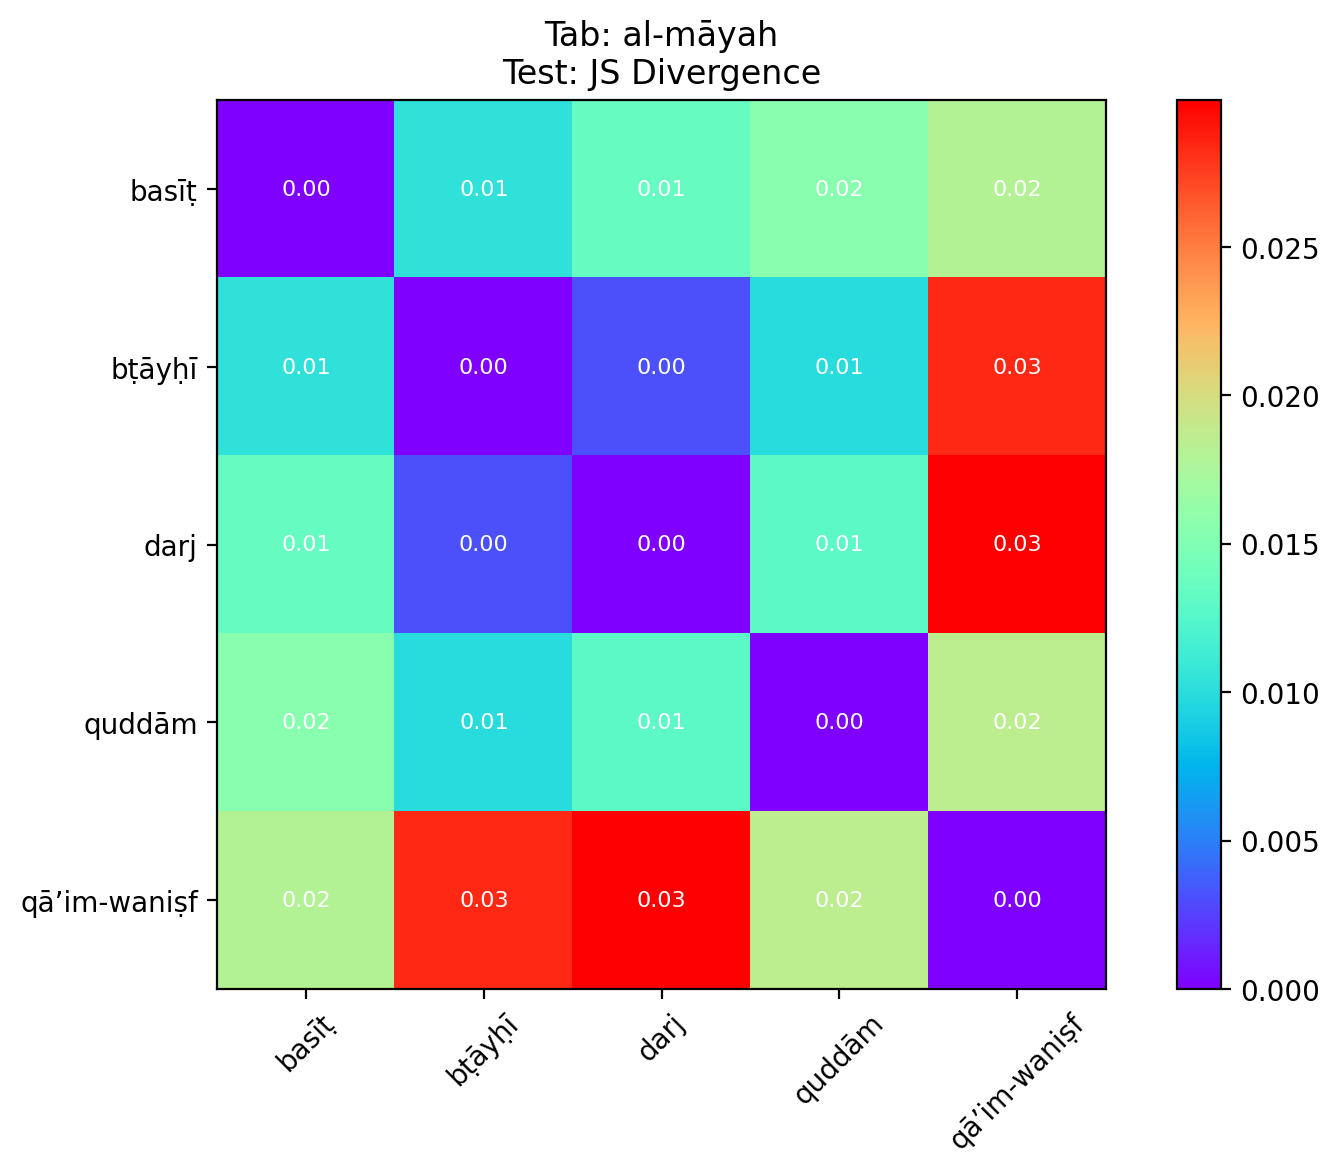

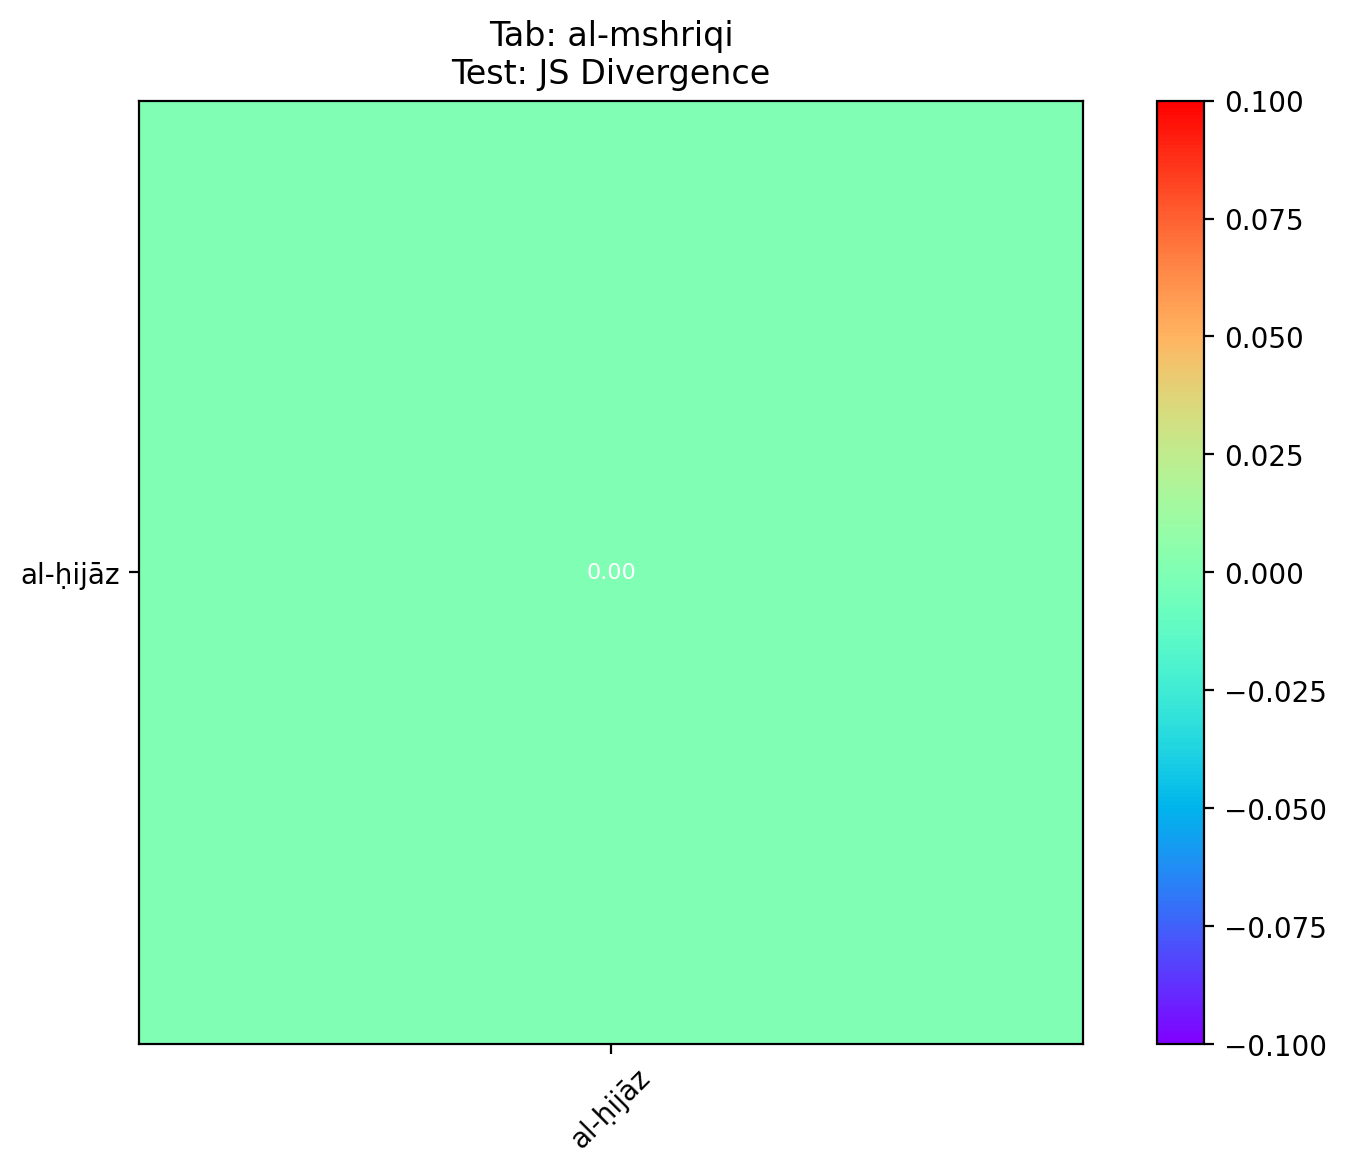

NEW TEST ---------------------------------------------------------------------------------


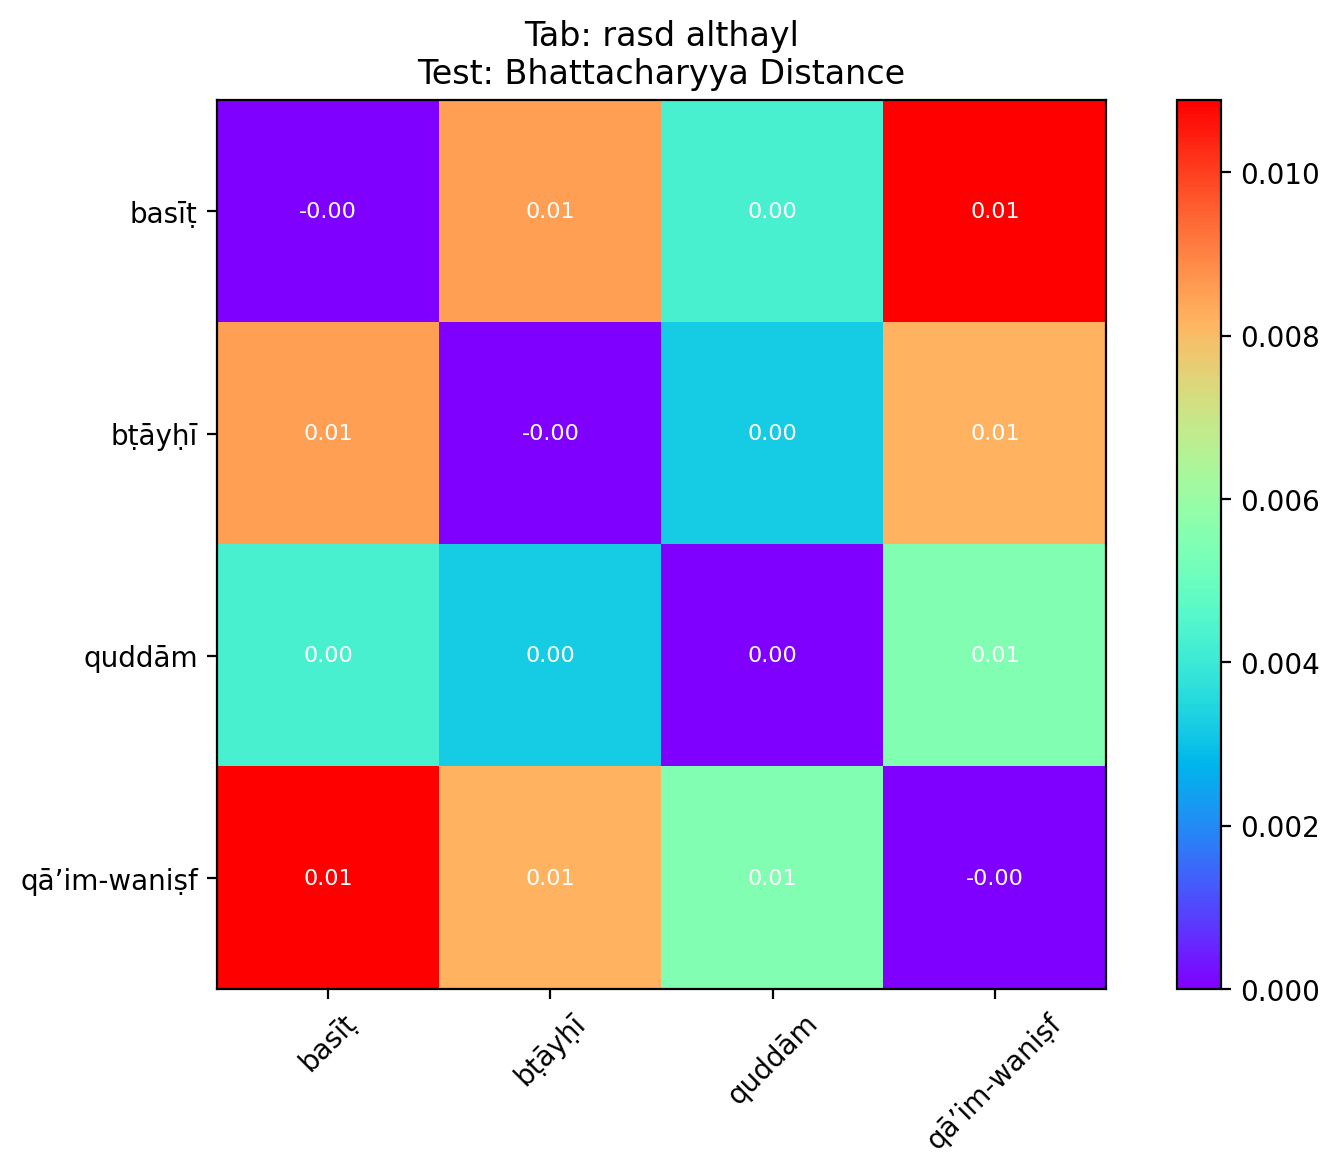

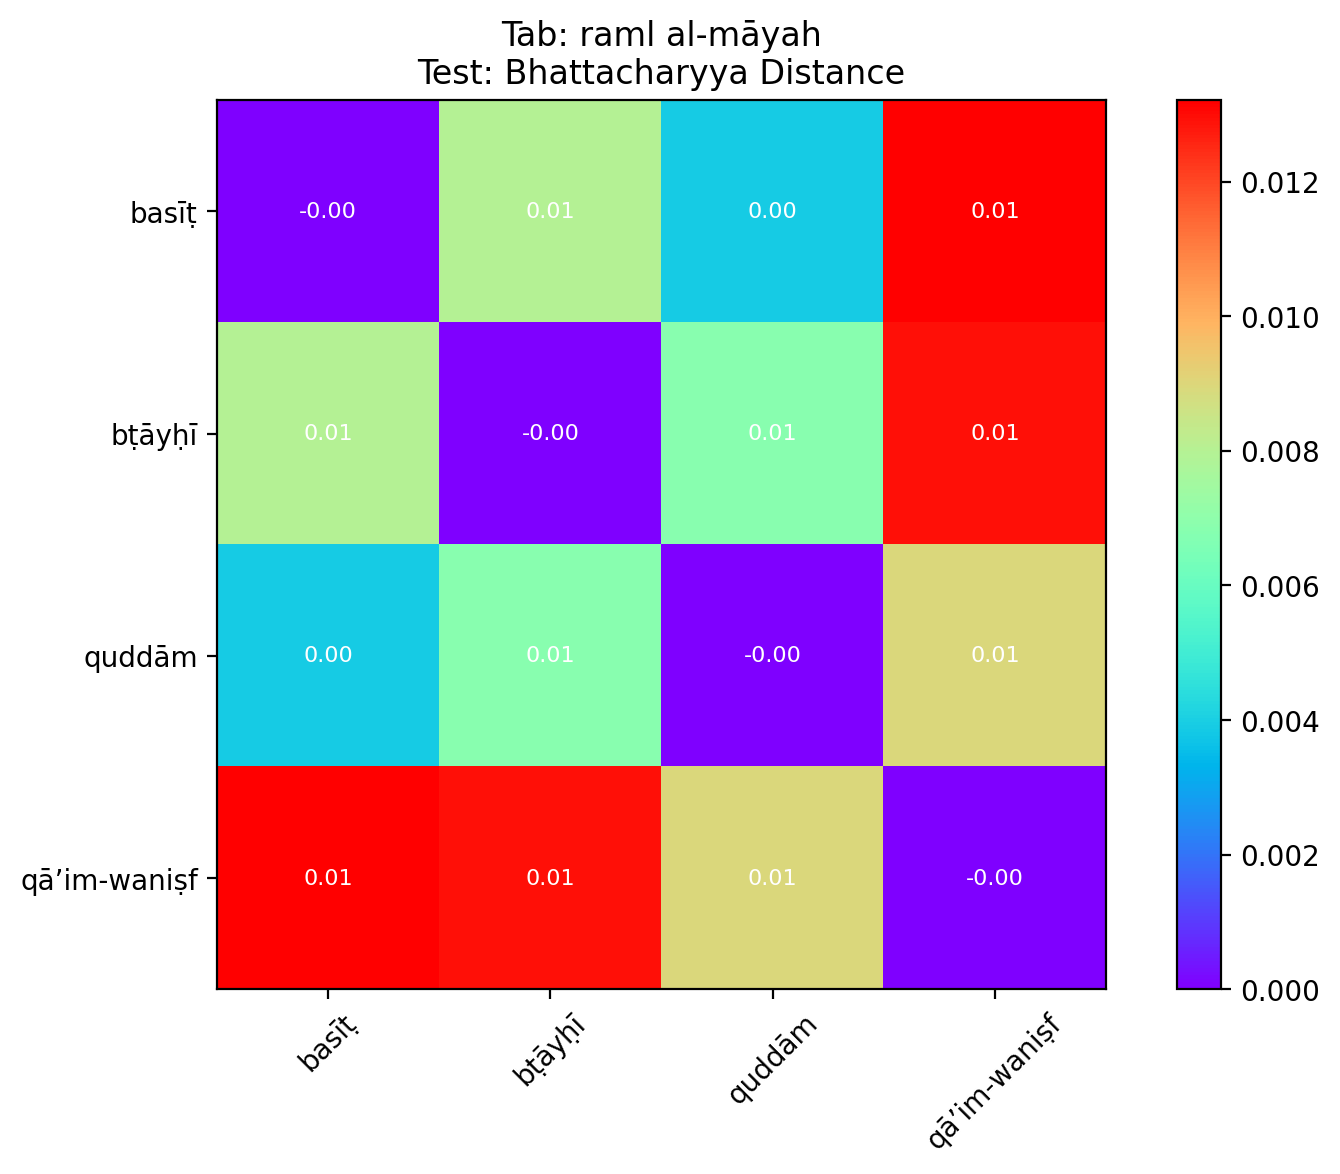

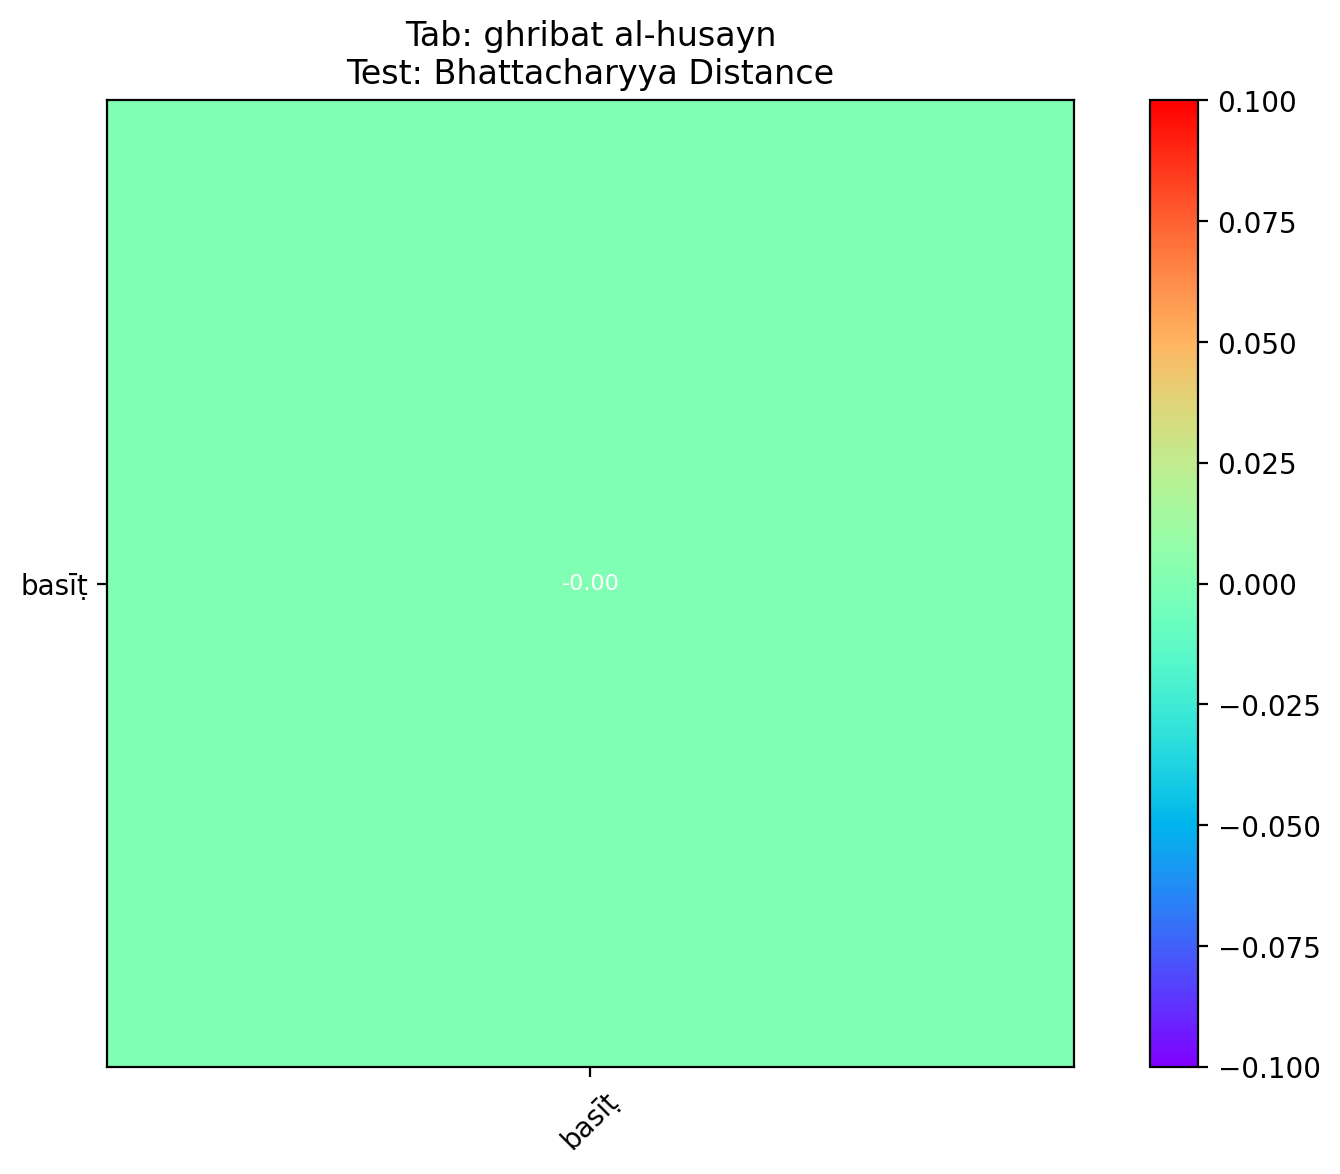

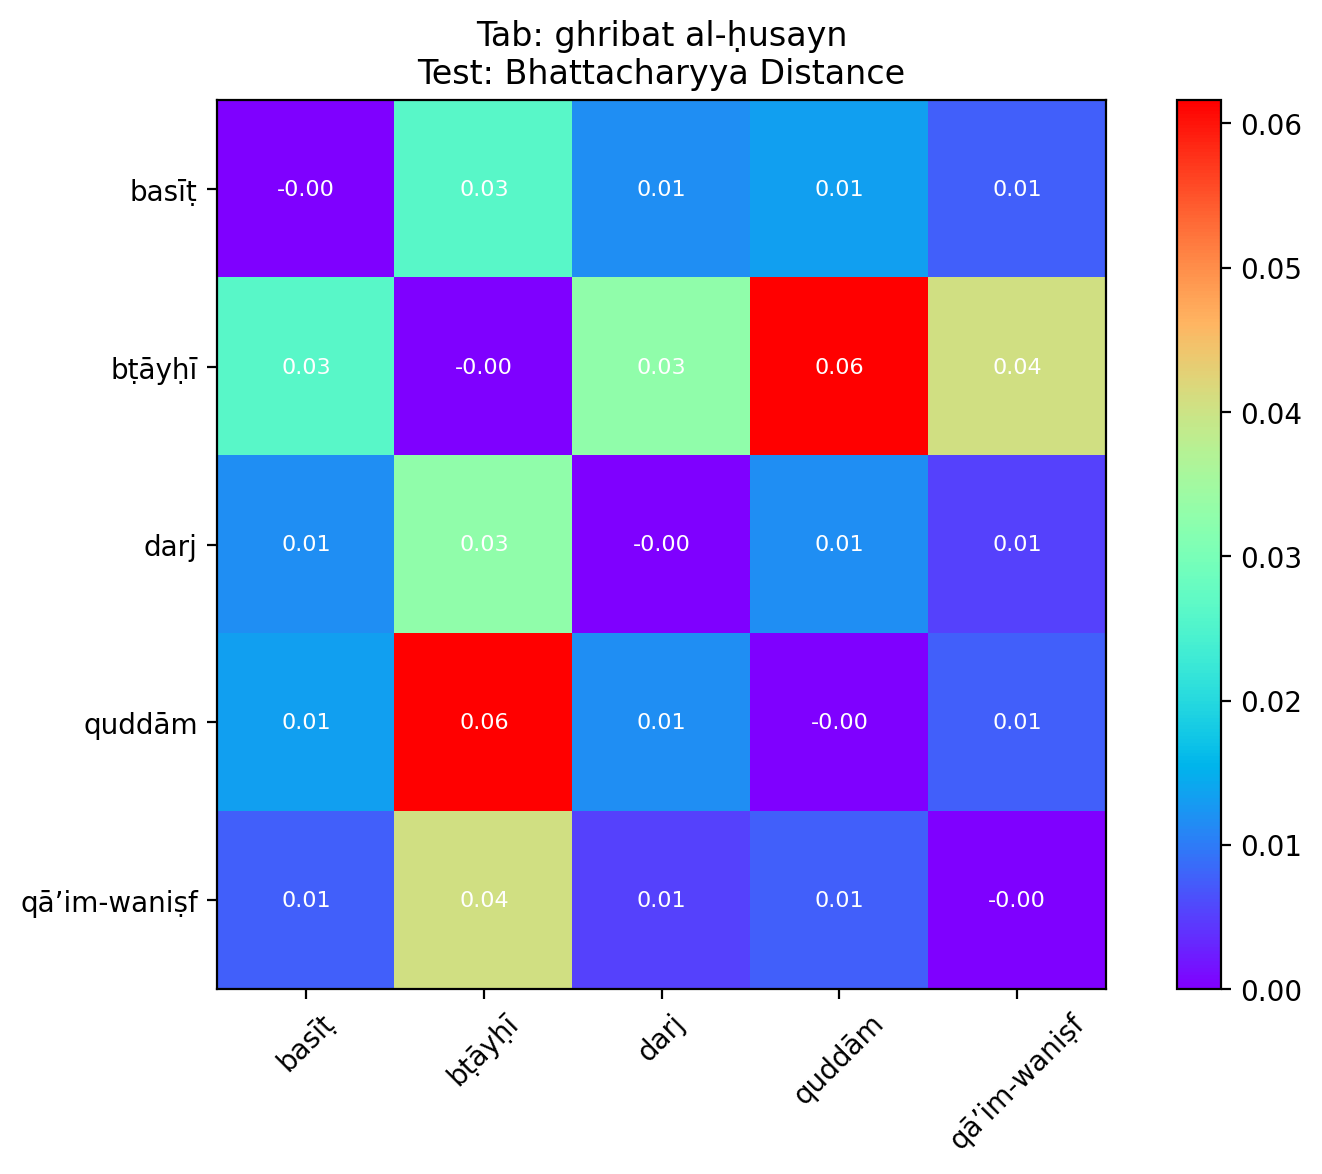

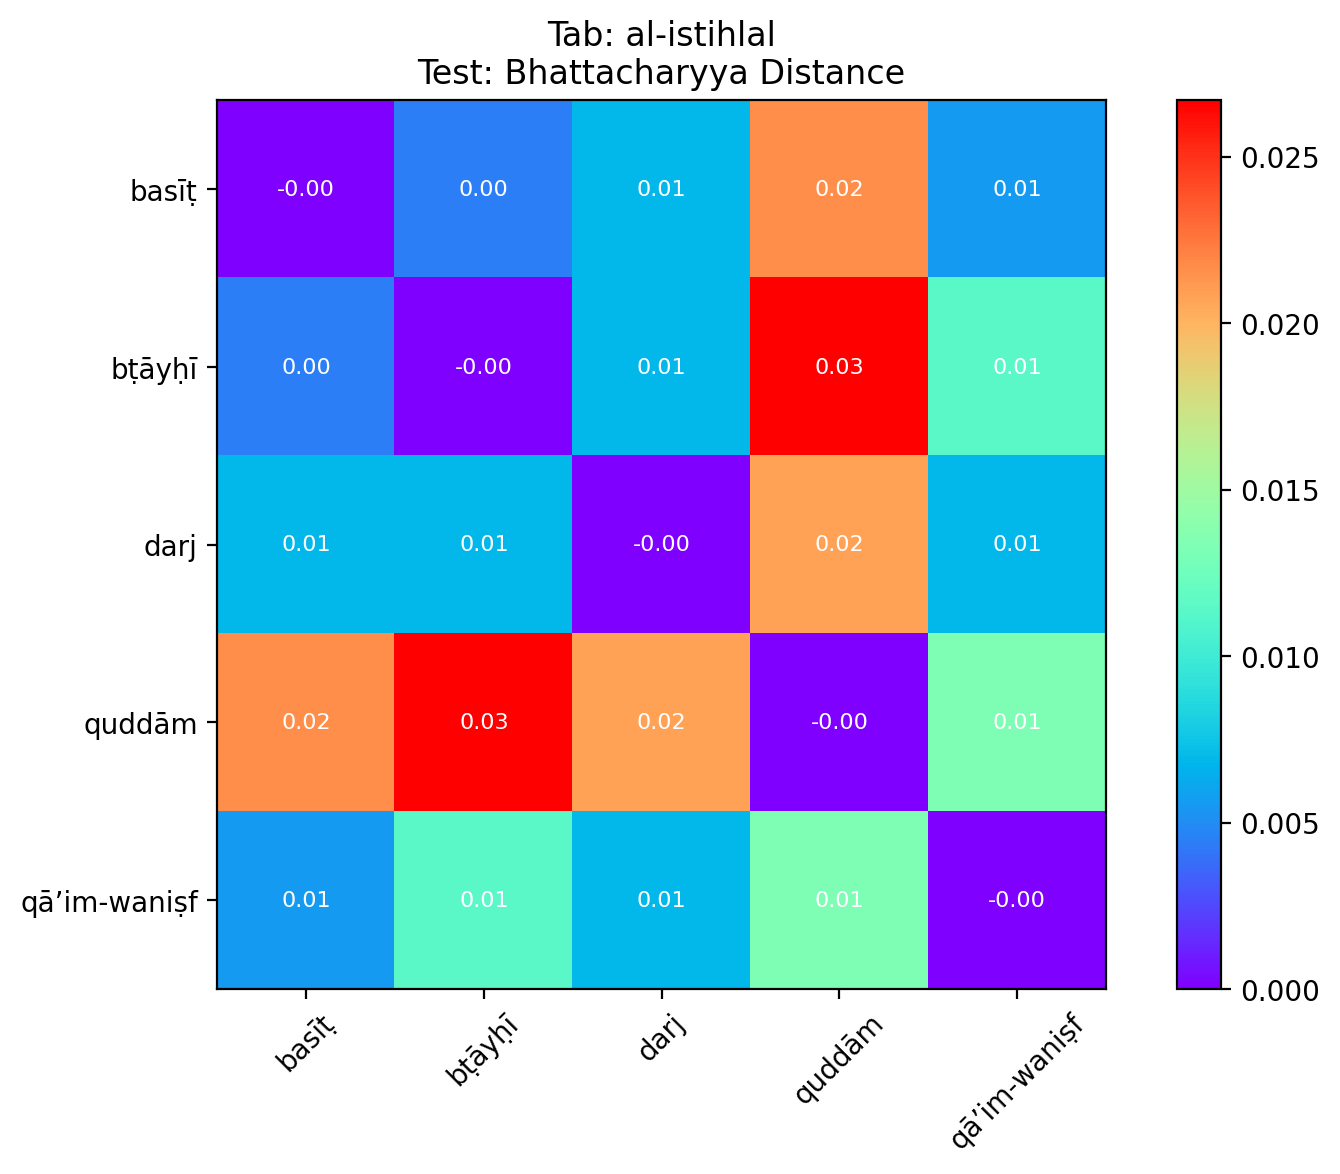

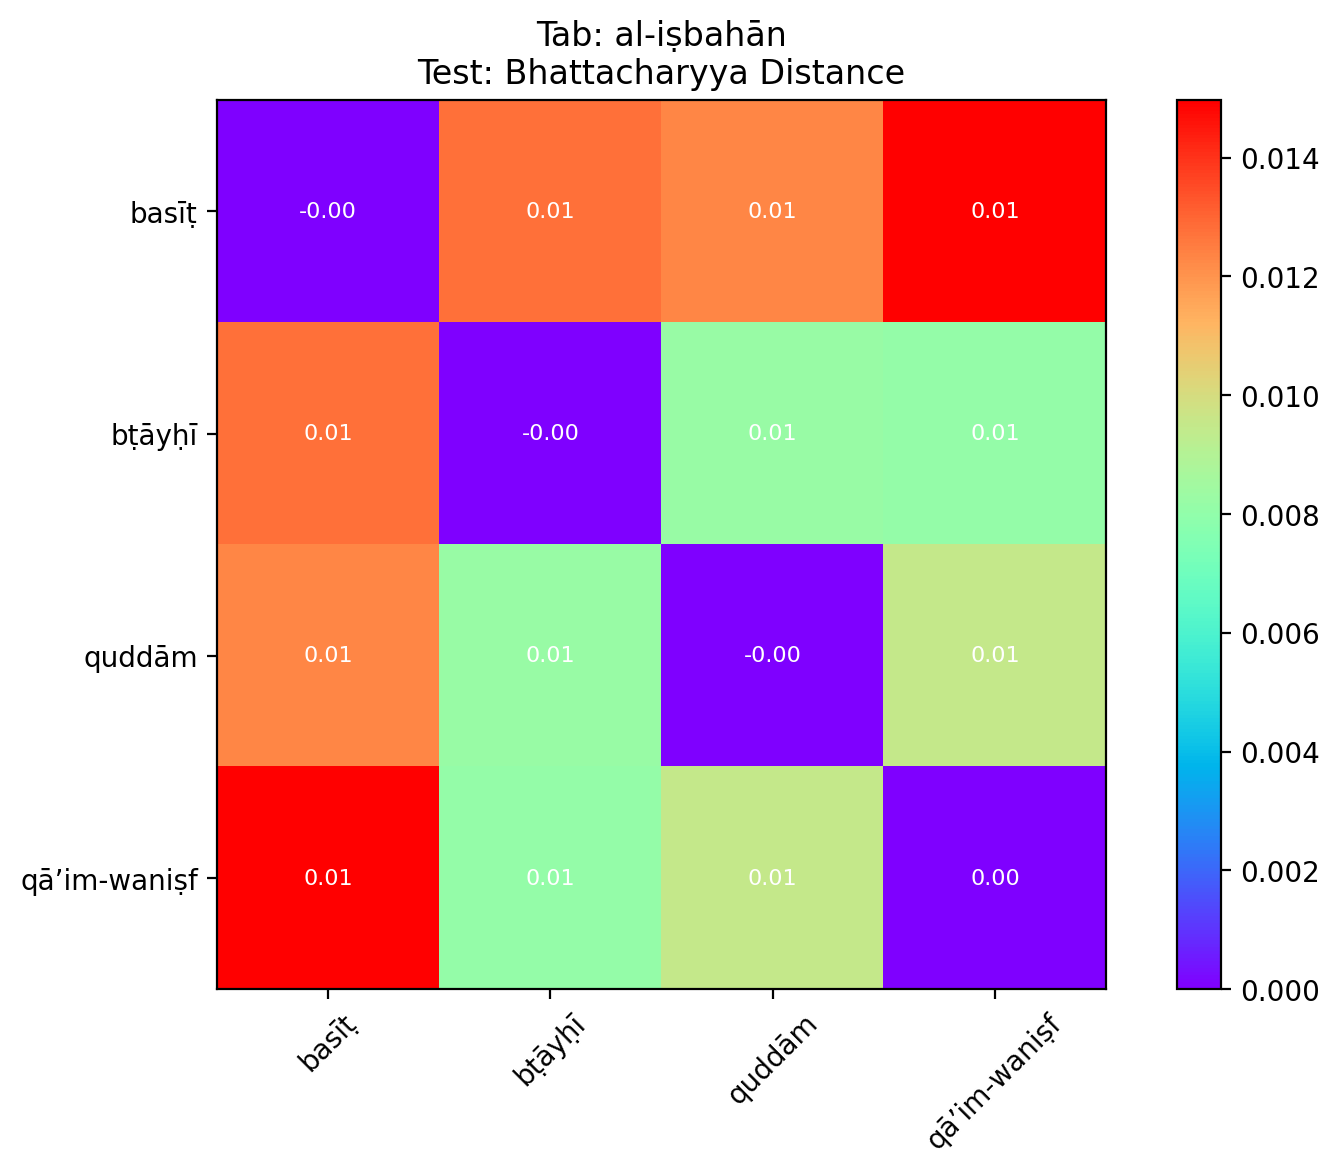

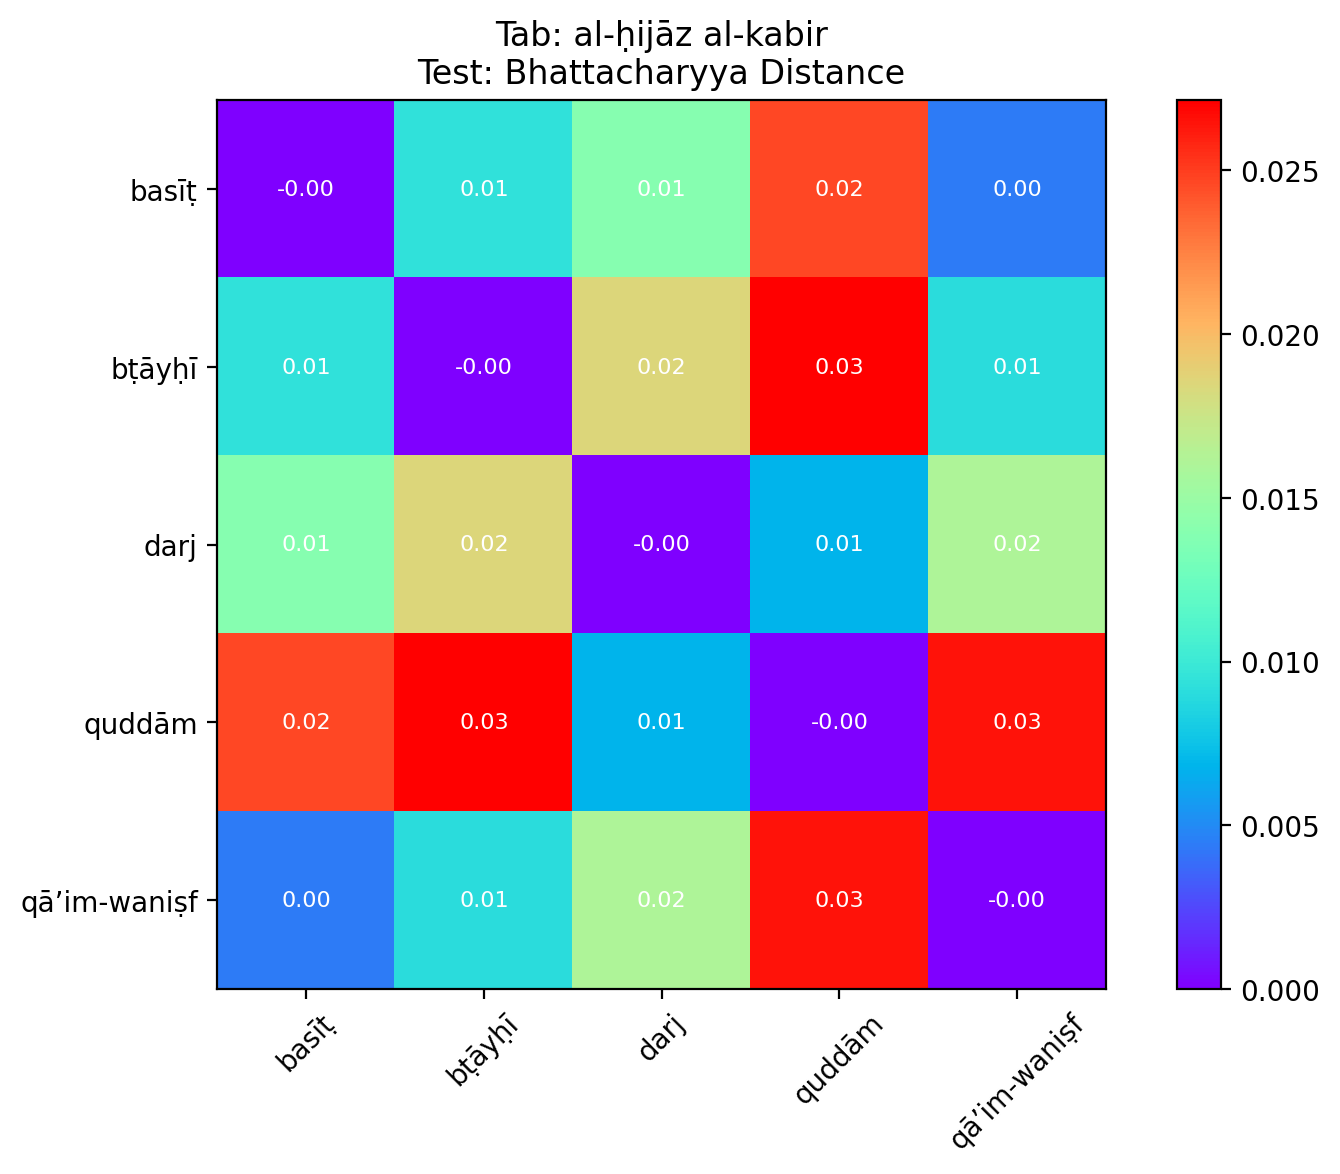

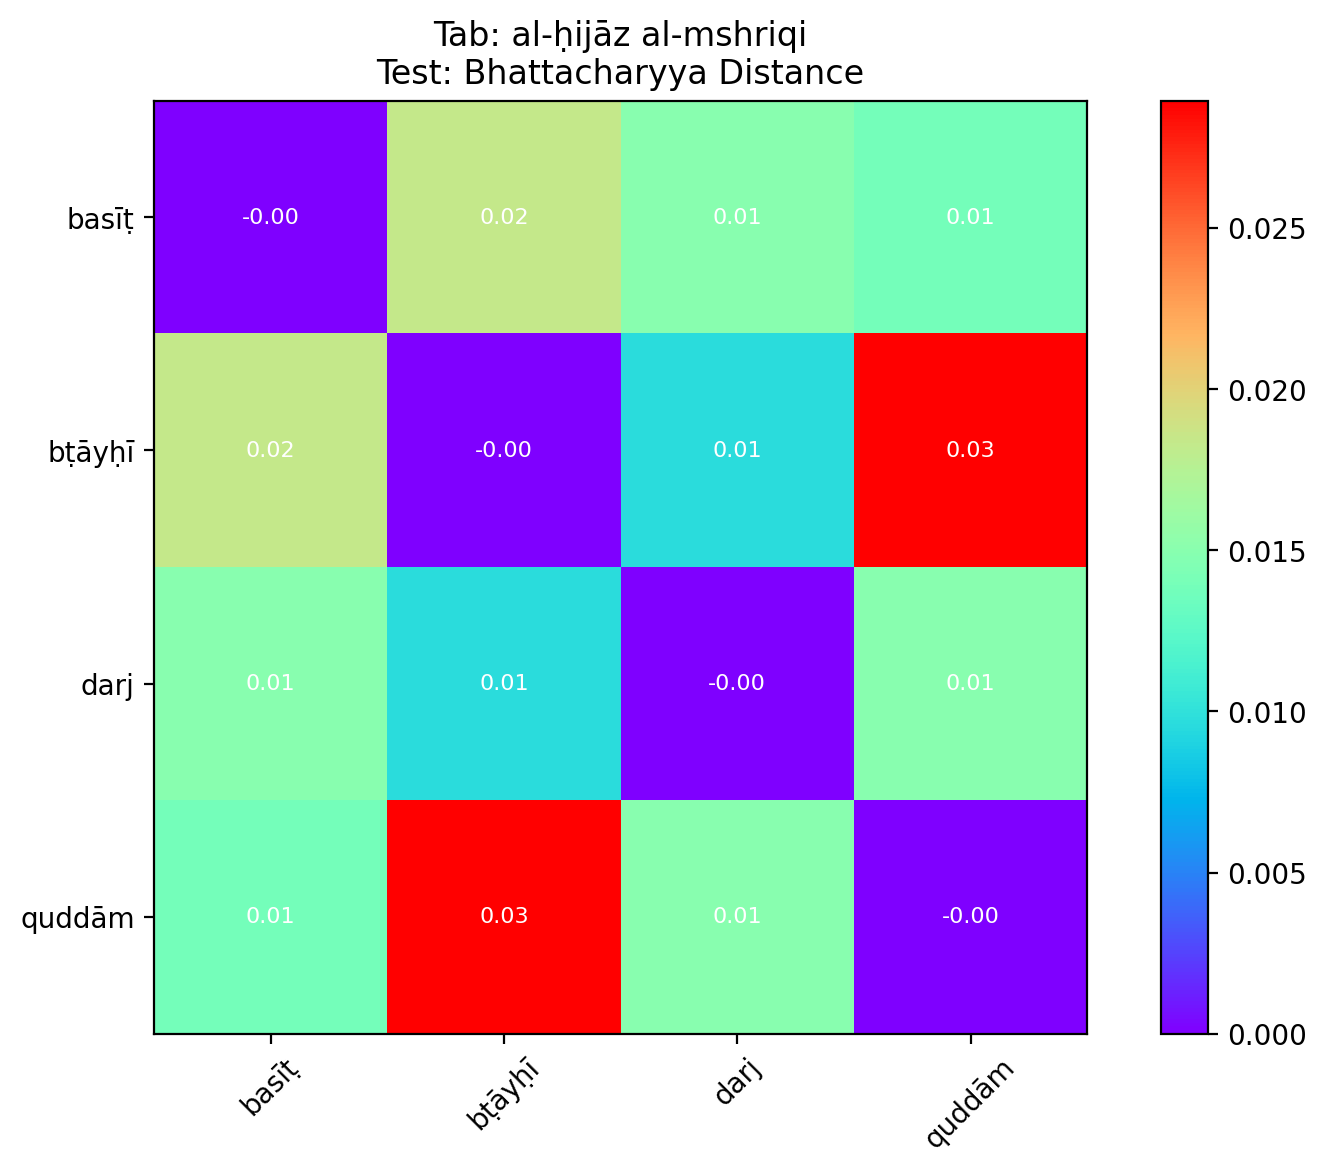

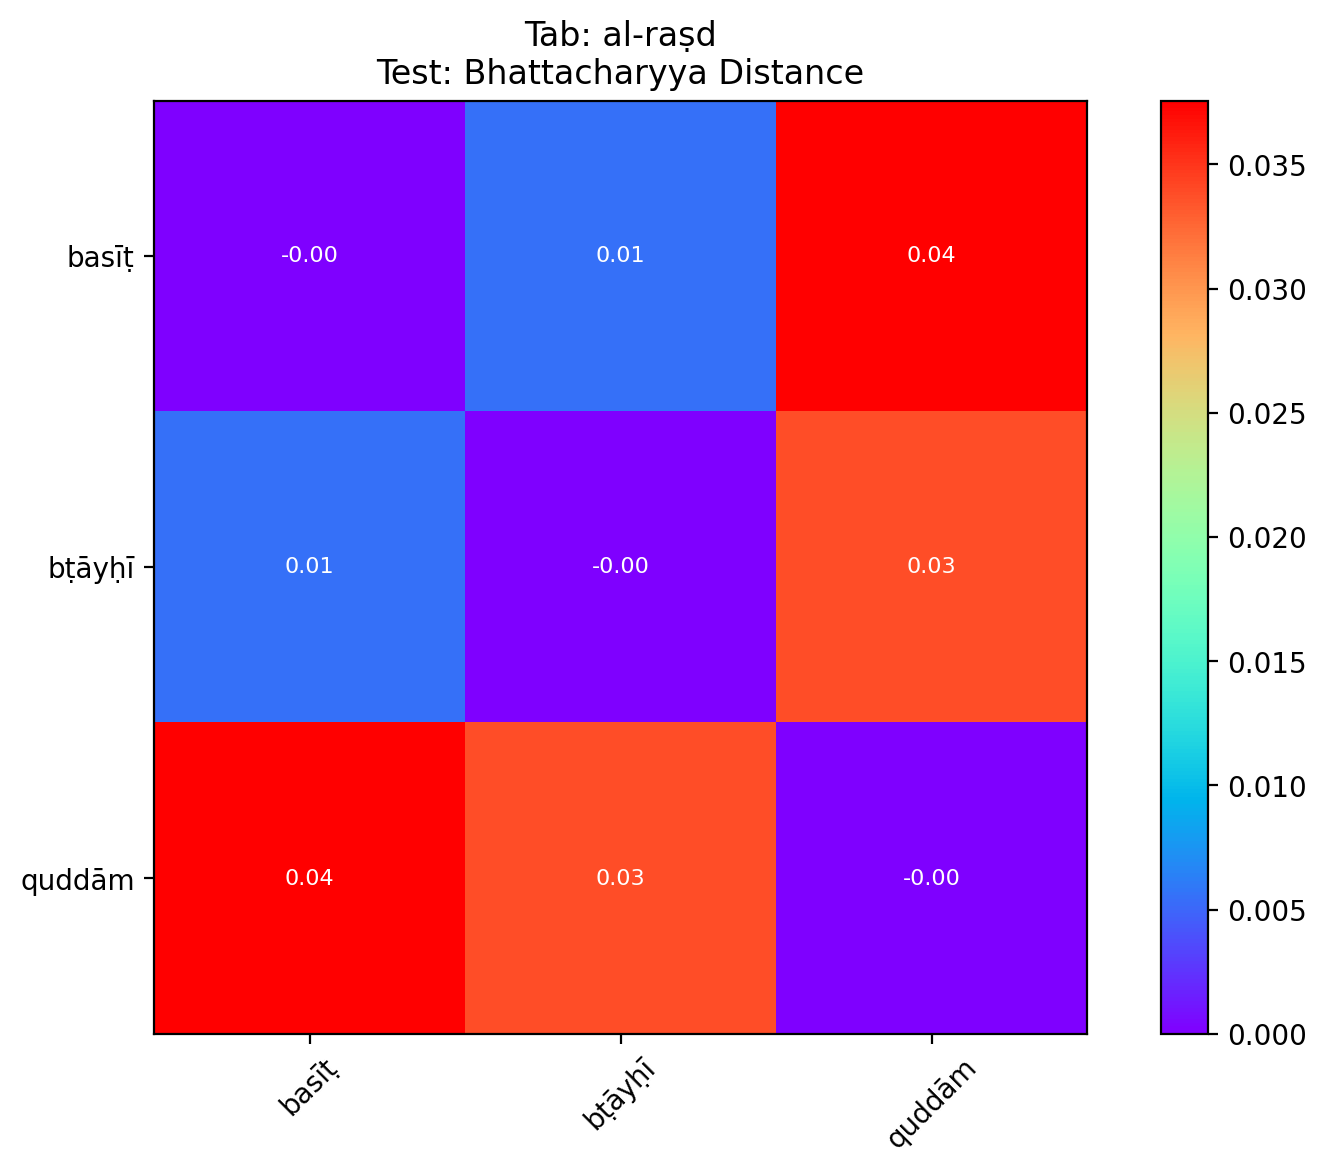

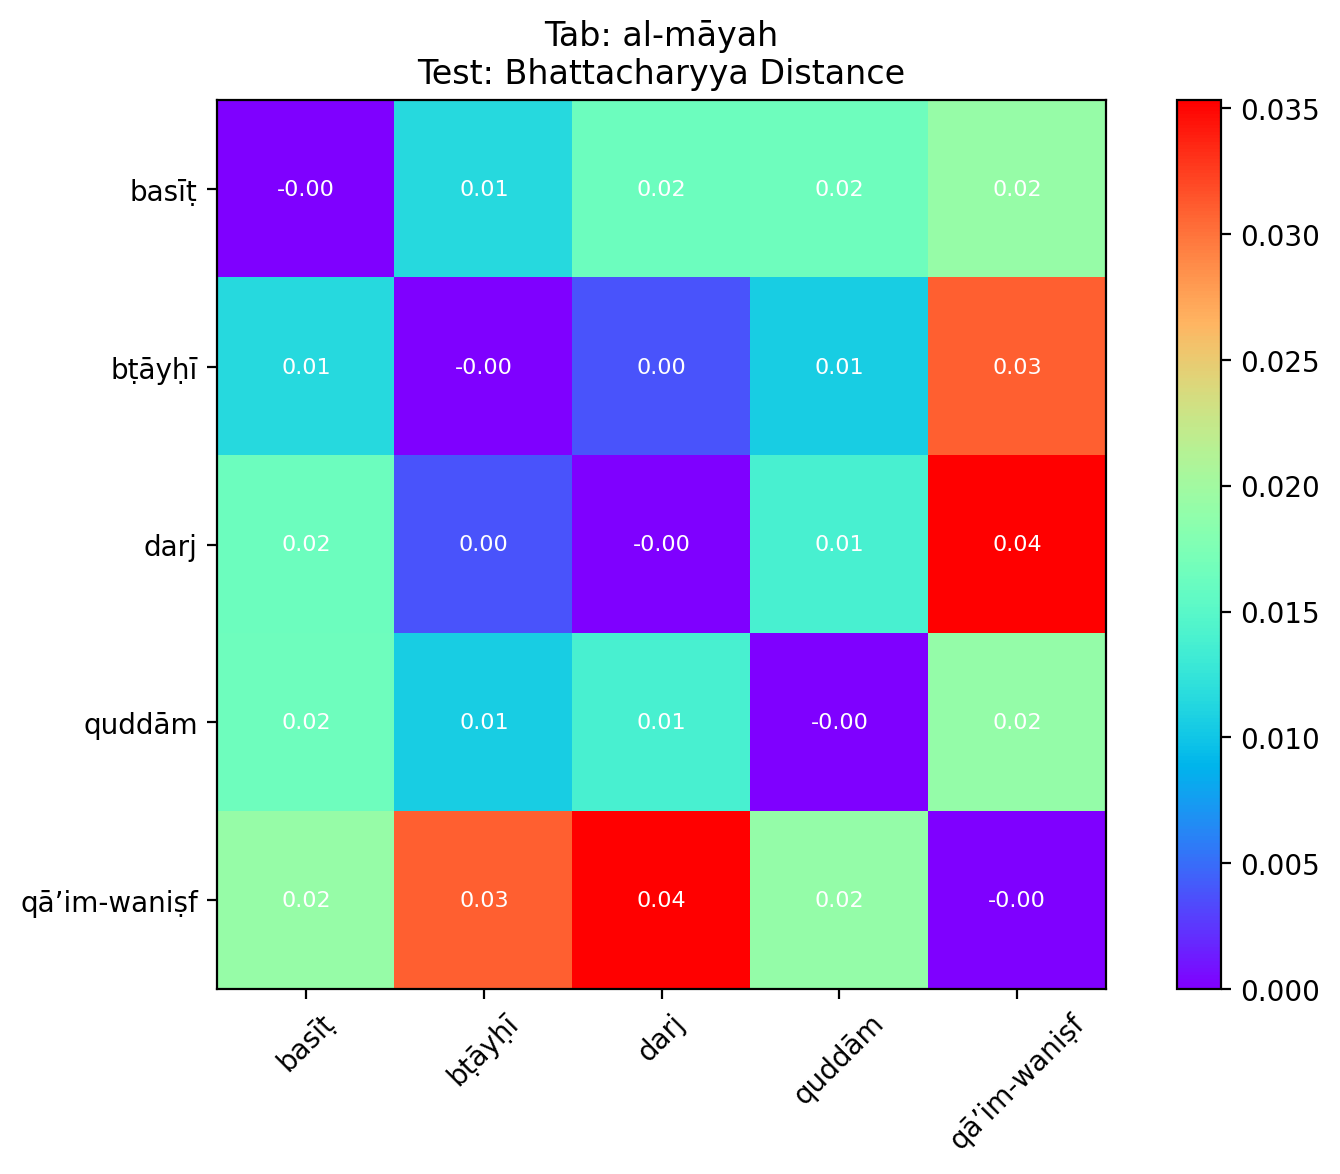

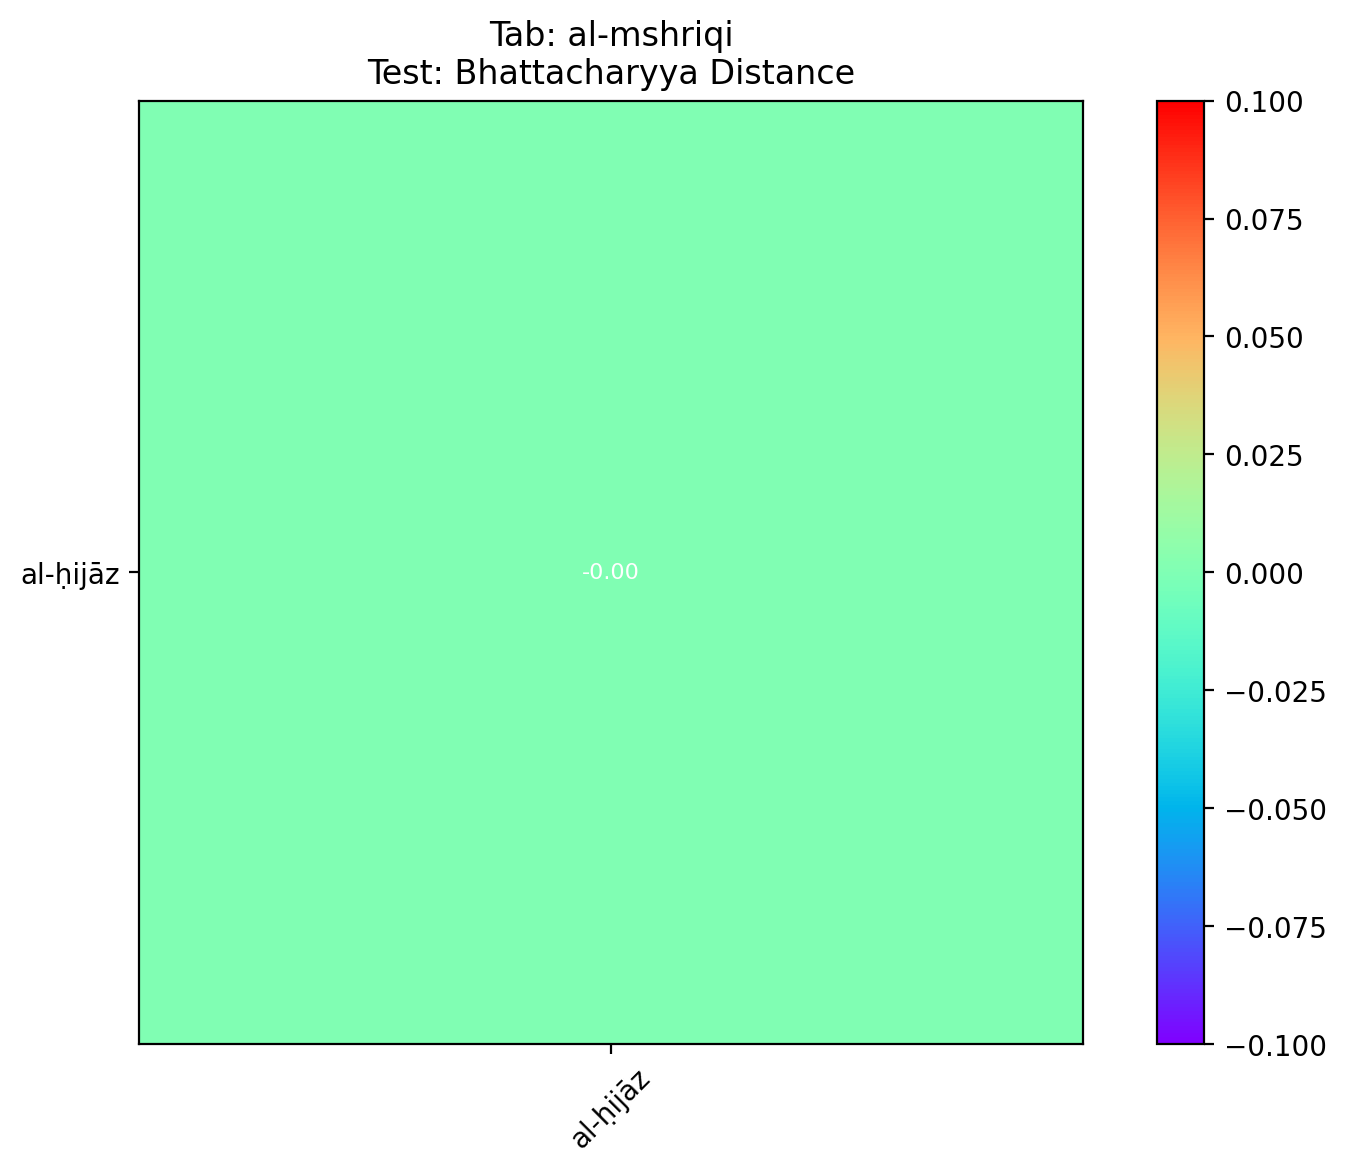

In [7]:
# Plot results
for name_test, test in tests.items():
    print("NEW TEST ---------------------------------------------------------------------------------")
    for tab in test.keys():
        contingency_table, class_1_labels, class_2_labels = u.create_contingency_table(test[tab])
        title="Tab: "+tab+"\nTest: "+name_test
        u.plot_contingency_table(contingency_table, class_1_labels, class_2_labels, title)